# Задача подготовки прототипа модели машинного обучения для «Цифры»

***
### Задача:

Нужно создать модель для предсказания коэффициента восстановления золота из золотосодержащей руды. Предоставлены данные с параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

<br/>

### Технологический процесс:

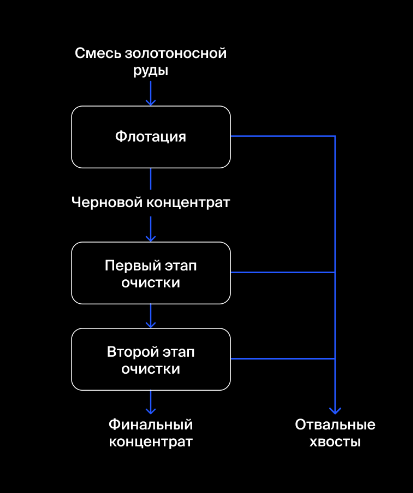

Обозначение этапов далее: 
* флотация - rougher
* первичная очистка - primary_cleaner 
* вторичная очистка - secondary_cleaner
* финальные характеристики - final

<br/>

### Описание данных:
    
* Данные находятся в трех файлах: 
    * gold_industry_train.csv — обучающая выборка;
    * gold_industry_test.csv — тестовая выборка;
    * gold_industry_full.csv — исходные данные.

* Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
* Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
* Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.
* В нашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверим по этой инструкции их на корректность.

    Параметры технологического процесса:
    * Rougher feed — исходное сырье
    * Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    * Xanthate — ксантогенат (промотер, или активатор флотации);
    * Sulphate — сульфат (на данном производстве сульфид натрия);
    * Depressant — депрессант (силикат натрия).
    * Rougher process (англ. «грубый процесс») — флотация
    * Rougher tails — отвальные хвосты
    * Float banks — флотационная установка
    * Cleaner process — очистка
    * Rougher Au — черновой концентрат золота
    * Final Au — финальный концентрат золота

    Параметры этапов:
    * air amount — объём воздуха
    * fluid levels — уровень жидкости
    * feed size — размер гранул сырья
    * feed rate — скорость подачи
    
    Типы параметров:
    
    * input — параметры сырья
    * output — параметры продукта
    * state — параметры, характеризующие текущее состояние этапа
    * calculation — расчётные характеристики

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.

Наименование признаков должно быть такое: [этап].[тип_параметра].[название_параметра]
    
Пример: `rougher.input.feed_ag`
    
<br/>

### Условия задачи:

Эффективность обогащения рассчитывается по формуле:

RECOVERY = (C*(F-T)* 100%) / (F*(C-T))

где:
C — доля золота в концентрате после флотации/очистки;
F — доля золота в сырье/концентрате до флотации/очистки;
T — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

Нужно спрогнозировать сразу две величины:

* эффективность обогащения чернового концентрата `rougher.output.recovery`;

* эффективность обогащения финального концентрата `final.output.recovery`.

<br/>

***

### План работы:

**[Шаг 1.](#section_1)** Загрузка  и подготовка данных.

**[Шаг 2.](#section_2)** Анализ данных.

**[Шаг 3.](#section_3)** Построение моделей.

**[Шаг 4.](#section_4)** Тестирование выбранной модели.

**[Шаг 5.](#section_5)** Общий вывод.

<br/>


<a id='section_1'></a>
### Шаг 1. Загрузка  и подготовка данных

#### 1.1 Загрузка данных и изучение общей информации

In [1]:
#Загрузка необходимых библиотек:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import shap

from sklearn.metrics import  make_scorer
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from matplotlib.colors import LinearSegmentedColormap

In [2]:
#Сохраняем данные в датафреймы
df_train = pd.read_csv('C:/Users/ratus/DATA_SCIENCE/итоговые проекты/7/gold_industry_train.csv')
df_test = pd.read_csv('C:/Users/ratus/DATA_SCIENCE/итоговые проекты/7/gold_industry_test.csv')
df_full = pd.read_csv('C:/Users/ratus/DATA_SCIENCE/итоговые проекты/7/gold_industry_full.csv')
    

In [3]:
#Общая информация по обучающему датафрейму 
#и несколько строк
df_train.info()
print (display(df_train.sample(5)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14579 non-null  object 
 1   rougher.input.feed_au                               14579 non-null  float64
 2   rougher.input.feed_ag                               14579 non-null  float64
 3   rougher.input.feed_pb                               14507 non-null  float64
 4   rougher.input.feed_sol                              14502 non-null  float64
 5   rougher.input.feed_rate                             14572 non-null  float64
 6   rougher.input.feed_size                             14478 non-null  float64
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 8   rougher.input.floatbank10_xanthate                  14572 non-null  float64


date  rougher.input.feed_au  rougher.input.feed_ag  \
5910   2016-11-01 07:59:59               9.724082              10.382902   
2884   2016-06-09 08:59:59               8.077164              10.119045   
13075  2017-10-04 03:59:59               6.745043               8.650523   
483    2016-02-06 14:00:00               6.975766               7.815967   
14405  2017-12-01 23:59:59               9.657002              12.113081   

       rougher.input.feed_pb  rougher.input.feed_sol  rougher.input.feed_rate  \
5910                3.743033               39.084566               456.685191   
2884                2.206084               42.627917               478.135083   
13075               3.285432               39.912213               577.413116   
483                 2.721600               37.307483               564.329288   
14405               5.405596               28.431578               508.700942   

       rougher.input.feed_size  rougher.input.floatbank10_sulfate  \
5910                 46.068685                          14.000177   
2884                 59.338296                          13.003109   
13075               114.835466                           7.928873   
483                  58.628890                          12.938873   
14405                63.680452                          15.252470   

       rougher.input.floatbank10_xanthate  rougher.state.floatbank10_a_air  \
5910                             5.998800                      1000.435458   
2884                             6.299449                       998.392896   
13075                            7.601904                      1306.297298   
483                              7.403678                       999.693515   
14405                            6.785144                      1297.818998   

       ...  secondary_cleaner.output.tail_sol  final.output.concentrate_au  \
5910   ...                          12.041054                    42.042444   
2884   ...                          11.045197                    47.300888   
13075  ...                           1.875735                    47.388683   
483    ...                          10.155367                    42.103671   
14405  ...                                NaN                     1.063992   

       final.output.concentrate_ag  final.output.concentrate_pb  \
5910                      6.963553                     9.520725   
2884                      4.925678                     7.221204   
13075                     4.583551                     9.984815   
483                       6.098068                    10.391891   
14405                     0.289059                     0.332391   

       final.output.concentrate_sol  final.output.recovery  \
5910                      14.008483              76.544204   
2884                      13.190683              74.690745   
13075                      8.583462              72.561407   
483                        3.732341              68.023210   
14405                      0.291099             100.000000   

       final.output.tail_au  final.output.tail_ag  final.output.tail_pb  \
5910               2.771535             11.383462              3.018809   
2884               2.343118             10.713390              2.058738   
13075              2.063905             10.095471              1.998406   
483                2.513952             10.742393              1.492146   
14405              0.000000              0.000000              0.000000   

       final.output.tail_sol  
5910               11.805815  
2884               11.853321  
13075               9.243621  
483                17.044335  
14405               0.000000  

[5 rows x 87 columns]

None


In [4]:
#Общая информация по тестовому датафрейму 
#и несколько строк
df_test.info()
print (display(df_test.sample(5)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4860 non-null   object 
 1   rougher.input.feed_au                       4860 non-null   float64
 2   rougher.input.feed_ag                       4860 non-null   float64
 3   rougher.input.feed_pb                       4832 non-null   float64
 4   rougher.input.feed_sol                      4838 non-null   float64
 5   rougher.input.feed_rate                     4856 non-null   float64
 6   rougher.input.feed_size                     4816 non-null   float64
 7   rougher.input.floatbank10_sulfate           4857 non-null   float64
 8   rougher.input.floatbank10_xanthate          4859 non-null   float64
 9   rougher.state.floatbank10_a_air             4859 non-null   float64
 10  rougher.stat

date  rougher.input.feed_au  rougher.input.feed_ag  \
4013  2018-07-03 02:59:59               8.432230              10.285341   
432   2017-12-29 23:59:59               7.735872               7.833009   
4195  2018-07-11 17:59:59               5.782546               6.904235   
471   2017-12-31 14:59:59               5.834999               5.554842   
4494  2018-07-31 06:59:59               6.599017               7.138930   

      rougher.input.feed_pb  rougher.input.feed_sol  rougher.input.feed_rate  \
4013               2.544935               38.281301               519.189379   
432                3.551006               39.905848               573.211977   
4195               2.510215               27.171296               416.272247   
471                3.879765               43.432120               552.585895   
4494               1.799329               33.137979               530.143595   

      rougher.input.feed_size  rougher.input.floatbank10_sulfate  \
4013                52.811335                          11.998801   
432                 76.586118                          11.010039   
4195                46.636943                          11.001742   
471                 74.308772                           8.624969   
4494                53.095511                           9.216710   

      rougher.input.floatbank10_xanthate  rougher.state.floatbank10_a_air  \
4013                            5.991807                       998.985815   
432                             6.105982                      1199.509474   
4195                            4.298051                      1000.721076   
471                             5.903379                      1207.677160   
4494                            6.543349                       998.482042   

      ...  secondary_cleaner.state.floatbank4_a_air  \
4013  ...                                 15.043026   
432   ...                                 30.042706   
4195  ...                                  9.001526   
471   ...                                 30.044379   
4494  ...                                 12.062538   

      secondary_cleaner.state.floatbank4_a_level  \
4013                                 -399.884739   
432                                  -494.343661   
4195                                 -548.317784   
471                                  -500.789891   
4494                                 -495.366459   

      secondary_cleaner.state.floatbank4_b_air  \
4013                                  5.030000   
432                                  21.968409   
4195                                  6.960951   
471                                  22.049197   
4494                                 11.984371   

      secondary_cleaner.state.floatbank4_b_level  \
4013                                 -399.285948   
432                                  -496.514717   
4195                                 -549.929750   
471                                  -500.494616   
4494                                 -498.668948   

      secondary_cleaner.state.floatbank5_a_air  \
4013                                 10.004478   
432                                  25.015701   
4195                                  7.945181   
471                                  25.020861   
4494                                 12.021770   

      secondary_cleaner.state.floatbank5_a_level  \
4013                                 -401.789780   
432                                  -500.755373   
4195                                 -550.778904   
471                                  -499.810634   
4494                                 -497.904602   

      secondary_cleaner.state.floatbank5_b_air  \
4013                                  4.914104   
432                                  23.001236   
4195                                  6.030613   
471                                  22.993582   
4494                                  9.922863   

      secondary_cleaner.state.floatbank5_b_l

None


In [5]:
#Общая информация по полному датафрейму 
#и несколько строк
df_full.info()
print (display(df_full.sample(5)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19339 non-null  float64
 4   rougher.input.feed_sol                              19340 non-null  float64
 5   rougher.input.feed_rate                             19428 non-null  float64
 6   rougher.input.feed_size                             19294 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 8   rougher.input.floatbank10_xanthate                  19431 non-null  float64


date  rougher.input.feed_au  rougher.input.feed_ag  \
2543   2016-05-25 19:59:59               6.767325               9.029444   
10188  2017-05-24 07:59:59               7.982723               7.848322   
2987   2016-06-14 00:59:59               8.027234               7.901779   
5509   2016-10-15 12:59:59               9.412145               9.985785   
8432   2017-02-25 07:59:59               6.836434               7.427734   

       rougher.input.feed_pb  rougher.input.feed_sol  rougher.input.feed_rate  \
2543                1.646339               40.305792               582.072706   
10188               3.456345               43.806594               610.341722   
2987                3.399599               33.544106               416.125833   
5509                3.858534               34.622963               393.927215   
8432                3.213347               34.808280               430.939816   

       rougher.input.feed_size  rougher.input.floatbank10_sulfate  \
2543                 52.168355                          11.999247   
10188                63.282054                          17.999972   
2987                 50.082269                           9.998171   
5509                 43.475561                          10.001728   
8432                 49.427467                          15.998316   

       rougher.input.floatbank10_xanthate  rougher.state.floatbank10_a_air  \
2543                             5.697436                       996.143889   
10188                            5.990782                      1002.493491   
2987                             5.998030                       986.528072   
5509                             5.498627                       997.983727   
8432                             4.898914                      1000.148823   

       ...  secondary_cleaner.output.tail_sol  final.output.concentrate_au  \
2543   ...                          13.579404                    44.386532   
10188  ...                           0.971201                    45.570961   
2987   ...                           7.434477                    41.533187   
5509   ...                           9.921439                    47.008838   
8432   ...                           2.861656                    46.320606   

       final.output.concentrate_ag  final.output.concentrate_pb  \
2543                      6.308949                     7.777812   
10188                     5.026765                    10.885644   
2987                      7.175354                     9.956534   
5509                      4.146553                     8.731920   
8432                      4.018887                    10.952900   

       final.output.concentrate_sol  final.output.recovery  \
2543                      10.060313              75.822142   
10188                      6.674334              79.789593   
2987                      11.668659              58.350052   
5509                      13.710393              67.498592   
8432                       8.181732              63.436320   

       final.output.tail_au  final.output.tail_ag  final.output.tail_pb  \
2543               1.850064              9.119501              1.234776   
10188              1.875473              6.961824              2.162162   
2987               3.768309              8.471305              2.551703   
5509               3.537106             10.836328              3.645316   
8432               2.757857              8.306170              2.981936   

       final.output.tail_sol  
2543               13.633746  
10188              12.914274  
2987                9.986052  
5509                9.190656  
8432               10.026701  

[5 rows x 87 columns]

None


В обучающем датасете у нас содержится информация о 14579 наблюдениях по 87 признакам.

В тестовом датасете у нас содержится информация о 4860 наблюдениях по 53 признакам.

В общем датасете у нас содержится информация о 19439 наблюдениях по 87 признакам.

Признаков в тестовой выборке значительно меньше, скорее всего, часть признаков мы не можем знать в момент оценки и предсказаний.


Во всех датафреймах заметно что есть пропуски в данных, надо будет далее посмотреть подробнее.

snapecase в названиях соблюден, все маленькими буквами, однако необходиом заменить все точки в названии на нижние подчеркивания.

С типами данных считаем что все в порядке, только тип данных для признака `data` надо будет заменить на datetime. Возможно этот признак перед моделированием можно будет удалить, так как по логике он не должен оказывать влияния на коэффициент восстановления золота из руды.

#### 1.2 Переименуем названия признаков

In [6]:
def parser(columns_name):
    """
    Функция для замены точек на нижние подчеркивания
    Получает названия признаков
    Возвращает словарик, где в качестве ключей имена старых 
    признаков, а в качестве значений новые имена с нижними 
    подчеркиваниями
    """
    #Создаем словарик, в котором ключами будут имена старых 
    #признаков,а значениями имена новых
    list_of_keys = columns_name
    new_columns_name = {k: 0 for k in list_of_keys}
    
    try:
        #Идем по списку наших имен и заменяем везде 
        #точки на нижние подчеркивания
        #обновленное имя добавляем в качестве значения 
        #в словарик new_columns_name
        for column_name in columns_name:
            new_columns_name[column_name] = column_name.replace('.', '_')
    except:
        print ('error in parser function')
    
    return(new_columns_name)
        

Переименуем для обучающего датафрейма:

In [7]:
#получим новые названия признаков
df_train_new_columns = parser(df_train.columns)

#Переименовываем
df_train = df_train.rename(columns = df_train_new_columns )

#Проверяем
df_train.columns

Index(['date', 'rougher_input_feed_au', 'rougher_input_feed_ag',
       'rougher_input_feed_pb', 'rougher_input_feed_sol',
       'rougher_input_feed_rate', 'rougher_input_feed_size',
       'rougher_input_floatbank10_sulfate',
       'rougher_input_floatbank10_xanthate', 'rougher_state_floatbank10_a_air',
       'rougher_state_floatbank10_a_level', 'rougher_state_floatbank10_b_air',
       'rougher_state_floatbank10_b_level', 'rougher_state_floatbank10_c_air',
       'rougher_state_floatbank10_c_level', 'rougher_state_floatbank10_d_air',
       'rougher_state_floatbank10_d_level', 'rougher_state_floatbank10_e_air',
       'rougher_state_floatbank10_e_level', 'rougher_state_floatbank10_f_air',
       'rougher_state_floatbank10_f_level',
       'rougher_input_floatbank11_sulfate',
       'rougher_input_floatbank11_xanthate',
       'rougher_calculation_sulfate_to_au_concentrate',
       'rougher_calculation_floatbank10_sulfate_to_au_feed',
       'rougher_calculation_floatbank11_sulfate

Переименуем признаки в тестовом датафрейме:

In [8]:
#получим новые названия признаков
df_test_new_columns = parser(df_test.columns)

#Переименовываем
df_test = df_test.rename(columns = df_test_new_columns )

#Проверяем
df_test.columns

Index(['date', 'rougher_input_feed_au', 'rougher_input_feed_ag',
       'rougher_input_feed_pb', 'rougher_input_feed_sol',
       'rougher_input_feed_rate', 'rougher_input_feed_size',
       'rougher_input_floatbank10_sulfate',
       'rougher_input_floatbank10_xanthate', 'rougher_state_floatbank10_a_air',
       'rougher_state_floatbank10_a_level', 'rougher_state_floatbank10_b_air',
       'rougher_state_floatbank10_b_level', 'rougher_state_floatbank10_c_air',
       'rougher_state_floatbank10_c_level', 'rougher_state_floatbank10_d_air',
       'rougher_state_floatbank10_d_level', 'rougher_state_floatbank10_e_air',
       'rougher_state_floatbank10_e_level', 'rougher_state_floatbank10_f_air',
       'rougher_state_floatbank10_f_level',
       'rougher_input_floatbank11_sulfate',
       'rougher_input_floatbank11_xanthate', 'primary_cleaner_input_sulfate',
       'primary_cleaner_input_depressant', 'primary_cleaner_input_feed_size',
       'primary_cleaner_input_xanthate',
       'prim

И в общем датафрейме

In [9]:
#получим новые названия признаков
df_full_new_columns = parser(df_full.columns)

#Переименовываем
df_full = df_full.rename(columns = df_full_new_columns )

#Проверяем
df_full.columns

Index(['date', 'rougher_input_feed_au', 'rougher_input_feed_ag',
       'rougher_input_feed_pb', 'rougher_input_feed_sol',
       'rougher_input_feed_rate', 'rougher_input_feed_size',
       'rougher_input_floatbank10_sulfate',
       'rougher_input_floatbank10_xanthate', 'rougher_state_floatbank10_a_air',
       'rougher_state_floatbank10_a_level', 'rougher_state_floatbank10_b_air',
       'rougher_state_floatbank10_b_level', 'rougher_state_floatbank10_c_air',
       'rougher_state_floatbank10_c_level', 'rougher_state_floatbank10_d_air',
       'rougher_state_floatbank10_d_level', 'rougher_state_floatbank10_e_air',
       'rougher_state_floatbank10_e_level', 'rougher_state_floatbank10_f_air',
       'rougher_state_floatbank10_f_level',
       'rougher_input_floatbank11_sulfate',
       'rougher_input_floatbank11_xanthate',
       'rougher_calculation_sulfate_to_au_concentrate',
       'rougher_calculation_floatbank10_sulfate_to_au_feed',
       'rougher_calculation_floatbank11_sulfate

#### 1.3 Проанализируем признаки, недоступные в тестовой выборке

In [10]:
#Посмотрим каких признаков нет в тестовой выборке
df_train.columns.difference(df_test.columns)

Index(['final_output_concentrate_ag', 'final_output_concentrate_au',
       'final_output_concentrate_pb', 'final_output_concentrate_sol',
       'final_output_recovery', 'final_output_tail_ag', 'final_output_tail_au',
       'final_output_tail_pb', 'final_output_tail_sol',
       'primary_cleaner_output_concentrate_ag',
       'primary_cleaner_output_concentrate_au',
       'primary_cleaner_output_concentrate_pb',
       'primary_cleaner_output_concentrate_sol',
       'primary_cleaner_output_tail_ag', 'primary_cleaner_output_tail_au',
       'primary_cleaner_output_tail_pb', 'primary_cleaner_output_tail_sol',
       'rougher_calculation_au_pb_ratio',
       'rougher_calculation_floatbank10_sulfate_to_au_feed',
       'rougher_calculation_floatbank11_sulfate_to_au_feed',
       'rougher_calculation_sulfate_to_au_concentrate',
       'rougher_output_concentrate_ag', 'rougher_output_concentrate_au',
       'rougher_output_concentrate_pb', 'rougher_output_concentrate_sol',
       'roughe

В тестовом датафрейме не хватает итоговых характеристик в концентрате и в хвостах после каждого этапа: флотации, первого и второго этапа очистки и финального, есть данные только "до". Поэтому исключим данные признаки из обущающего набора перед моделированием.

В том числе в тестовой выборке нет целевых признаков final.output.recovery и rougher.output.recovery

Добавим в тестовый датасет целевые признаки из общего датафрейма

In [11]:
print (df_test.shape)

(4860, 53)


In [12]:
#Вытащим нужные колонки из общего датасета во вспомогательный
data = df_full[['final_output_recovery','rougher_output_recovery','date']]

#Добавим в тестовую таблицу полученные колонки
df_test = df_test.merge(data, on='date', how='inner')

#Проверяем
print (df_test.columns)
print (df_test.shape)

Index(['date', 'rougher_input_feed_au', 'rougher_input_feed_ag',
       'rougher_input_feed_pb', 'rougher_input_feed_sol',
       'rougher_input_feed_rate', 'rougher_input_feed_size',
       'rougher_input_floatbank10_sulfate',
       'rougher_input_floatbank10_xanthate', 'rougher_state_floatbank10_a_air',
       'rougher_state_floatbank10_a_level', 'rougher_state_floatbank10_b_air',
       'rougher_state_floatbank10_b_level', 'rougher_state_floatbank10_c_air',
       'rougher_state_floatbank10_c_level', 'rougher_state_floatbank10_d_air',
       'rougher_state_floatbank10_d_level', 'rougher_state_floatbank10_e_air',
       'rougher_state_floatbank10_e_level', 'rougher_state_floatbank10_f_air',
       'rougher_state_floatbank10_f_level',
       'rougher_input_floatbank11_sulfate',
       'rougher_input_floatbank11_xanthate', 'primary_cleaner_input_sulfate',
       'primary_cleaner_input_depressant', 'primary_cleaner_input_feed_size',
       'primary_cleaner_input_xanthate',
       'prim

#### 1.4 Проверим данные на наличие аномальностей и выбросов

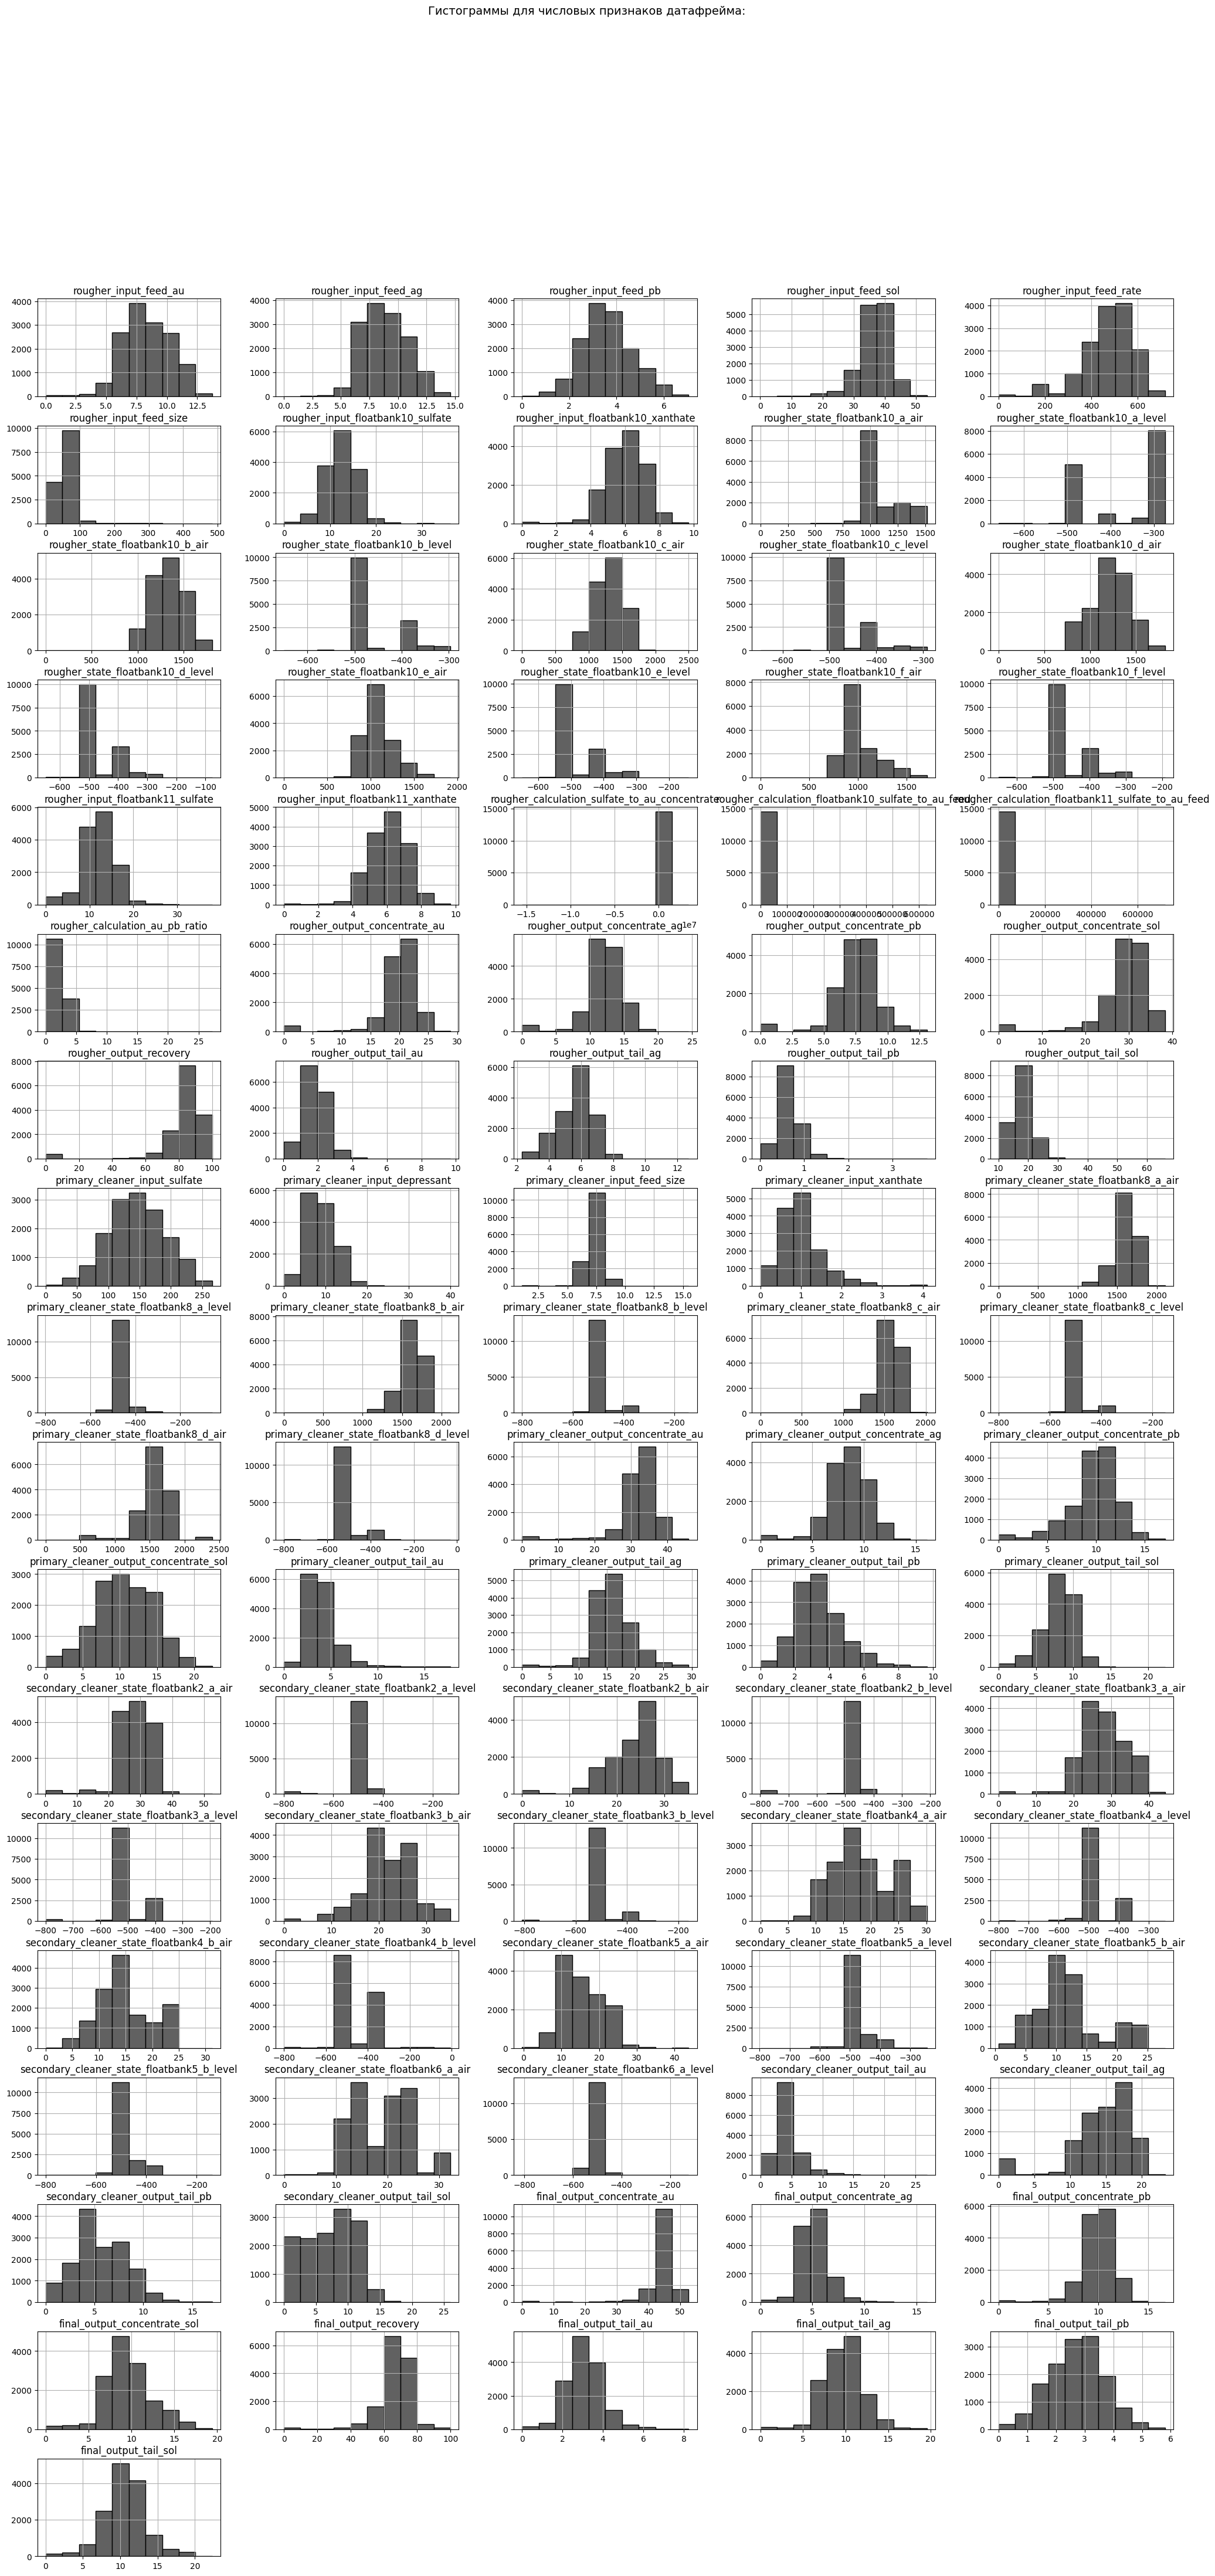

In [13]:
# Общая гистограмма для всех числовых столбцов
df_train.hist(figsize=(25, 50), layout=(18,5), 
              color = '#616161', edgecolor = 'black')
plt.suptitle('Гистограммы для числовых признаков датафрейма:', fontsize=14);

В обучающем датафрейме похоже на выбросы или наличие аномальных данных в следующих признаках (из тех, что будут участвовать в моделировании):

* rougher_input_feed_size
* rougher_state_floatbank10_a_air
* rougher_state_floatbank10_f_air
* rougher_state_floatbank10_e_air

Попробуем почистить аномалии и выбросы, так как чистка данных особенно для линейных моделей (а мы будем пробовать в том числе линейную регрессию) может улучшить результат.

Для всех признаков, в которых есть аномальные данные обрежем по 0.4 процентиля слева и справа (заменим на пустые значения).
 

In [14]:
#Признаки для обрезки аномальных значений и выбросов
columns = ['rougher_input_feed_size', 
           'rougher_state_floatbank10_a_air',
           'rougher_state_floatbank10_f_air', 
           'rougher_state_floatbank10_e_air',]


#перебирая признаки, находим для каждого процентили для обрезки
#и обрезаем данные
for column in columns:
    procentile_996 = df_train[column].quantile(.996)
    procentile_004 = df_train[column].quantile(.004)

    print(column, 'пустых значений до ', df_train[column].isna().sum())
    isna_before = df_train[column].isna().sum()

    df_train.loc[df_train[column]<procentile_004, column] = None
    df_train.loc[df_train[column]>procentile_996, column] = None

    print(column, 'пустых значений после ',df_train[column].isna().sum())
    

rougher_input_feed_size пустых значений до  101
rougher_input_feed_size пустых значений после  217
rougher_state_floatbank10_a_air пустых значений до  0
rougher_state_floatbank10_a_air пустых значений после  118
rougher_state_floatbank10_f_air пустых значений до  0
rougher_state_floatbank10_f_air пустых значений после  118
rougher_state_floatbank10_e_air пустых значений до  429
rougher_state_floatbank10_e_air пустых значений после  543


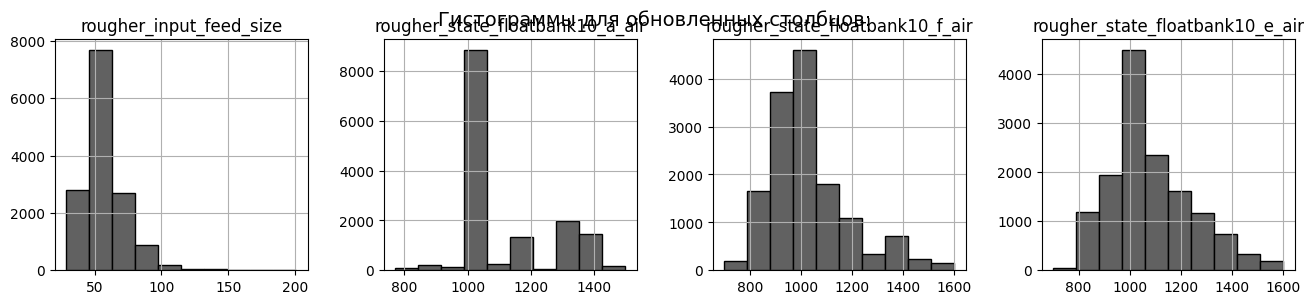

In [15]:
# Общая гистограмма для этих обновленных столбцов
df_train[columns].hist(figsize=(16, 3), layout=(1,4), 
             color = '#616161', edgecolor = 'black')
plt.suptitle('Гистограммы для обновленных столбцов:', fontsize=14);

Так, ну уже вроде получше, посмотрим теперь данные на наличие аномальностей и выбросов в тестовом датафрейме:

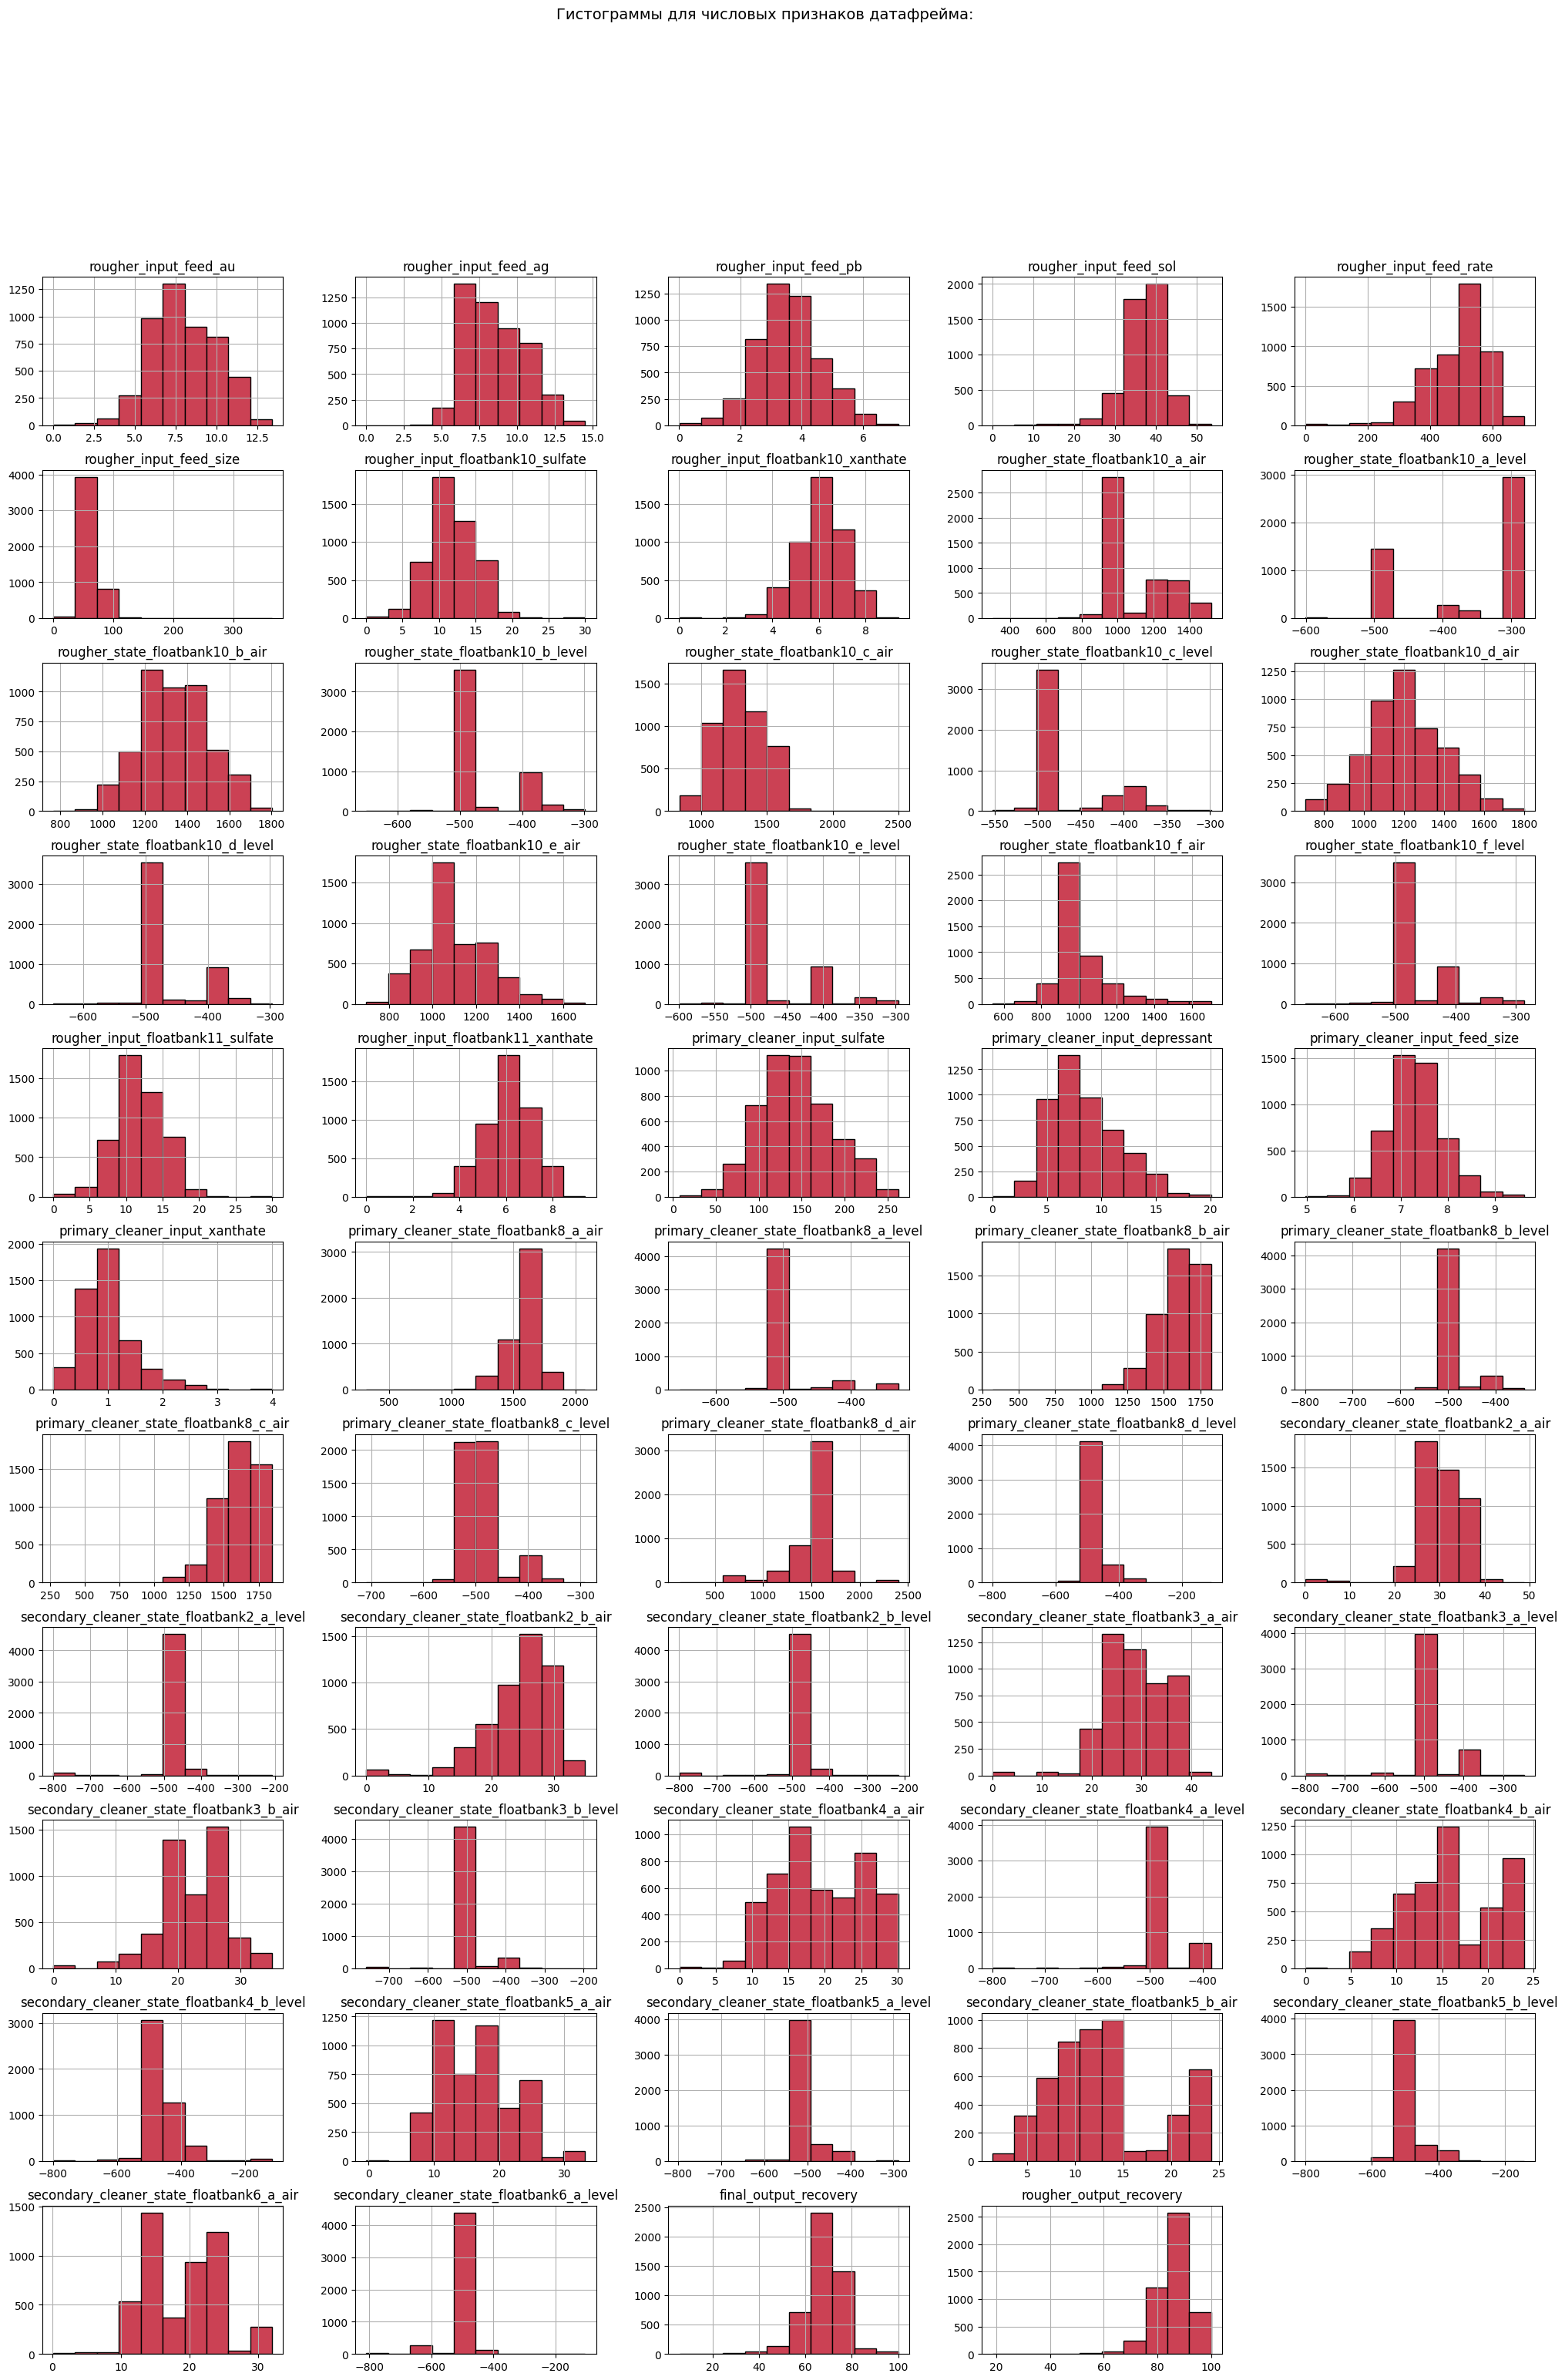

In [16]:
# Общая гистограмма для всех числовых столбцов
df_test.hist(figsize=(25, 35), layout=(11,5), 
             color = '#cb4154', edgecolor = 'black')
plt.suptitle('Гистограммы для числовых признаков датафрейма:', fontsize=14);

В тестовом датафрейме выбросов и аномальных данных можно сказать нет. Посмотрим на общий фрейм

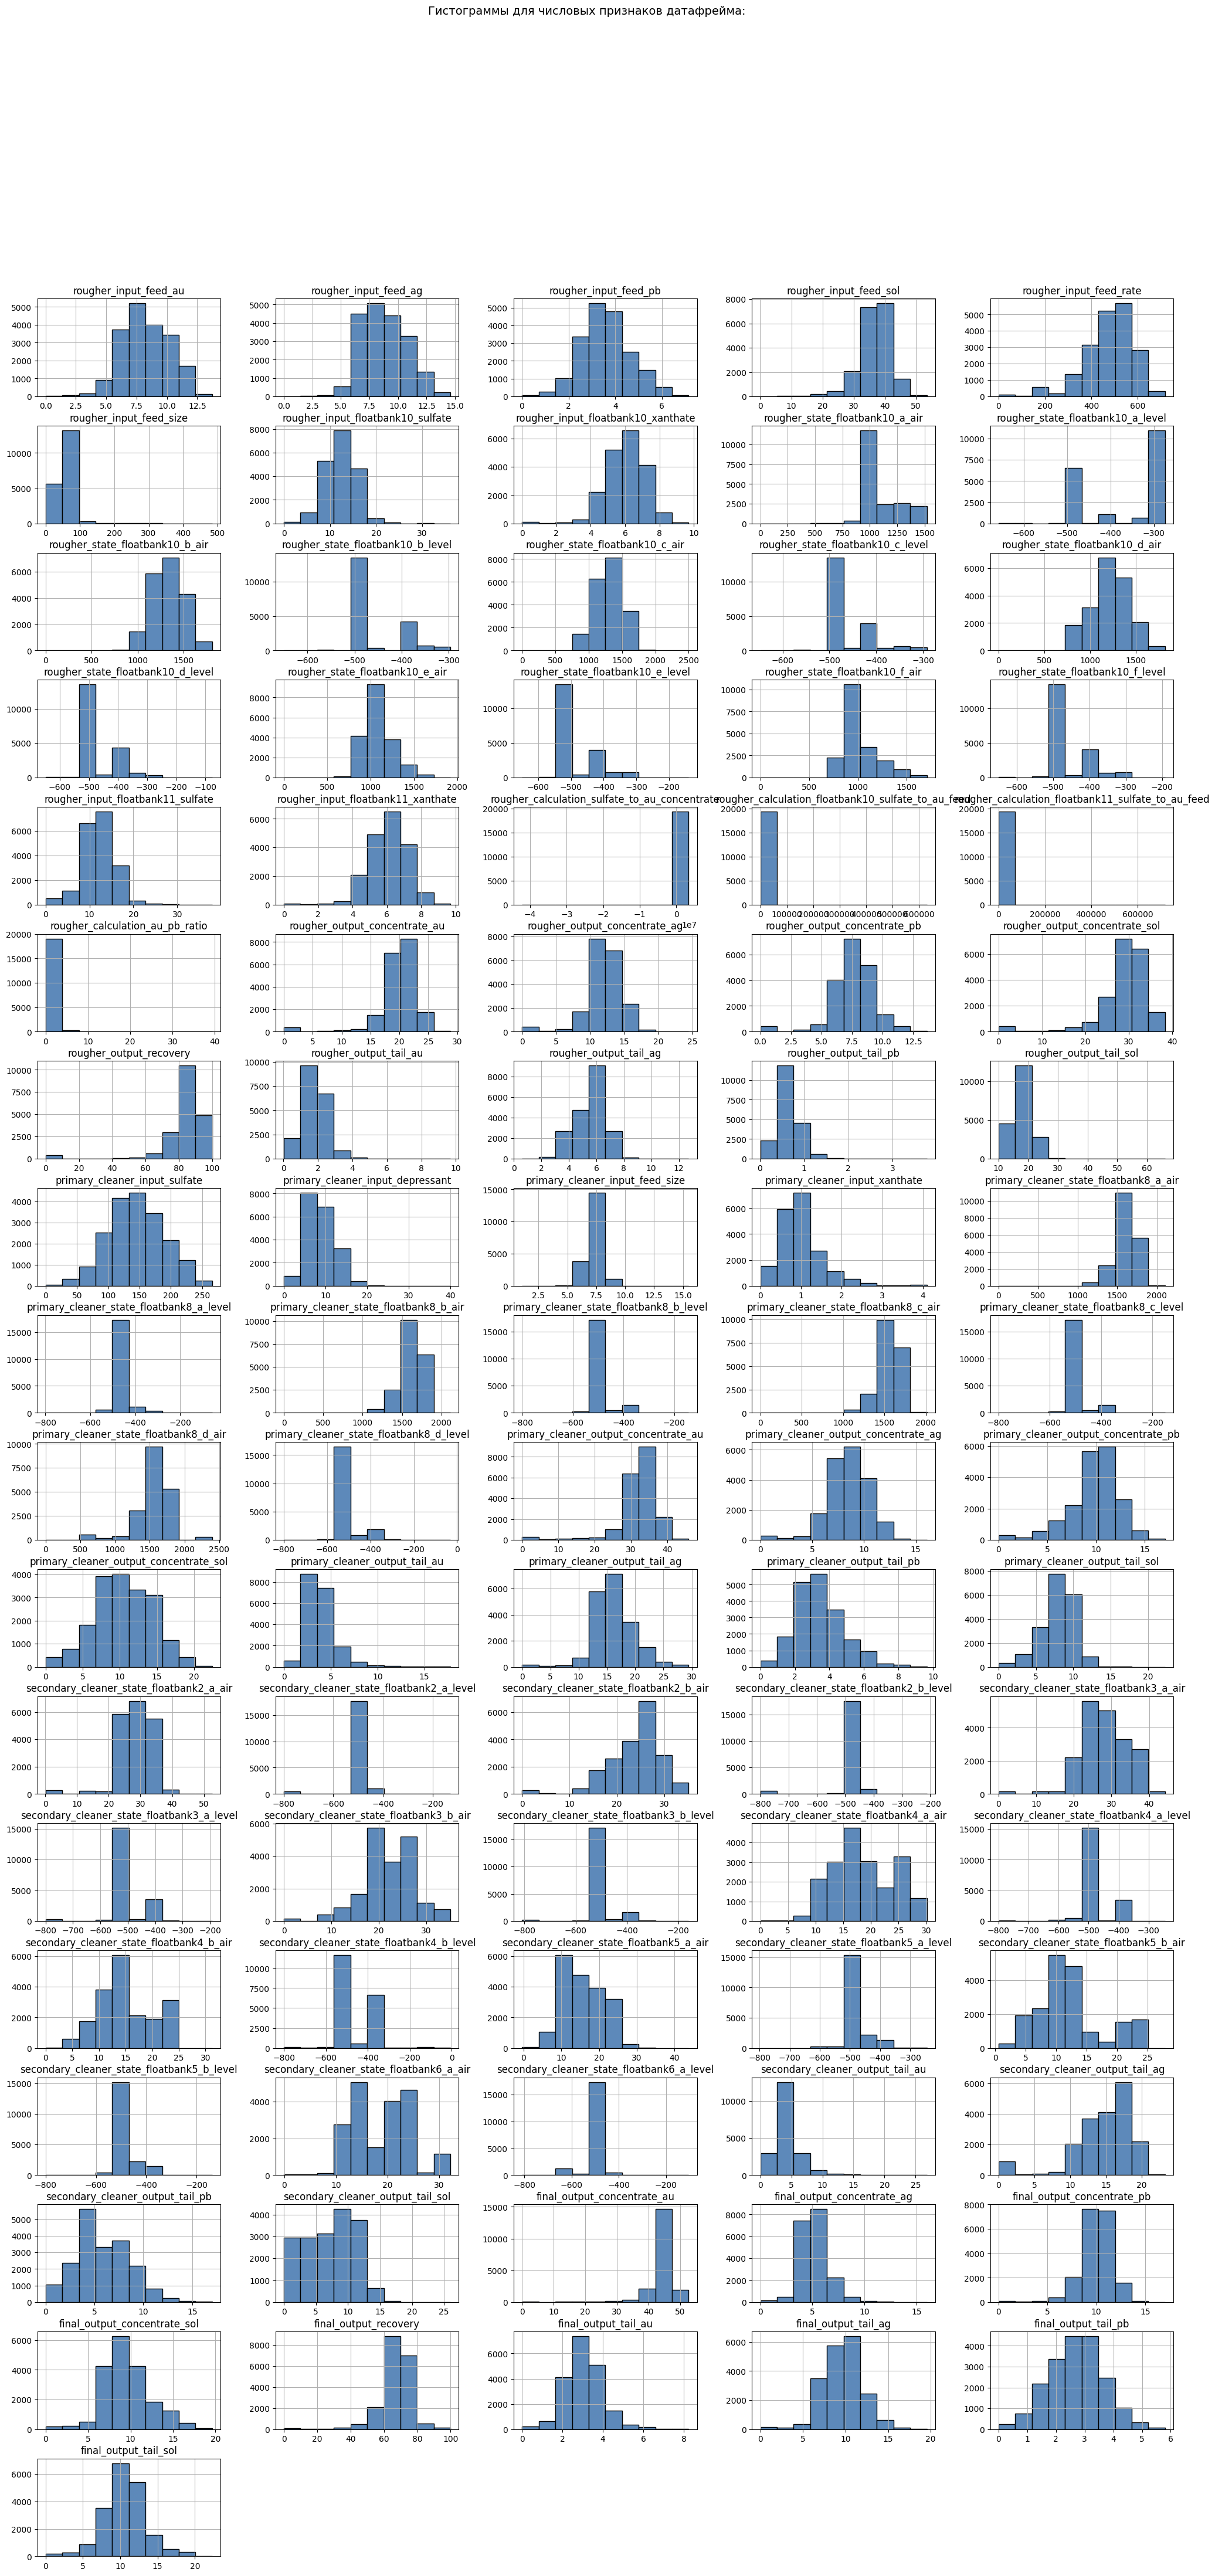

In [17]:
# Общая гистограмма для всех числовых столбцов
df_full.hist(figsize=(25, 50), layout=(18,5), 
             color = '#5d89ba', edgecolor = 'black')
plt.suptitle('Гистограммы для числовых признаков датафрейма:', fontsize=14);

В общем датафрейме похоже на выбросы или наличие аномальных данных в следующих признаках:

* rougher_input_feed_size
* rougher_state_floatbank10_a_air
* rougher_state_floatbank10_f_air
* rougher_state_floatbank10_e_air
* 'rougher_calculation_sulfate_to_au_concentrate'
* rougher_calculation_floatbank10_sulfate_to_au_feed
* rougher_calculation_floatbank11_sulfate_to_au_feed
* rougher_calculation_au_pb_ratio
* secondary_cleaner_output_tail_au
* final_output_concentrate_au

Общий датафрейм оставим пока так. Если понадобится тут избавится от аномалий, вернемся.

#### 1.5 Проверка расчетов

Проверим, что эффективность обогащения рассчитана правильно для признака `rougher_output_recovery`. 


In [18]:
#Вычислим эффективность обагащения после этапа флотации
c =  df_train['rougher_output_concentrate_au']
f = df_train['rougher_input_feed_au']
t = df_train['rougher_output_tail_au']
check_r_o_recovery = c*(f-t)*100/(f*(c-t))

# Найдем среднее абсолютное отклонение
#между имеющимся признаком и посчитанным нами:
print ('MAE =', mean_absolute_error(df_train['rougher_output_recovery'],check_r_o_recovery))

MAE = 1.1181885454685472e-14


Ответы совпадают с точностью до 13 знака после запятой, что говорит о том, что эффективность обогащения рассчитана верно.

#### 1.6 Подробнее про пропуски в датафреймах:

Выведем для обучающего датафрейма столбцы, в которых есть пропуски с указанием процента пропущенных значений

In [19]:
def table_of_missing_data(data):
    """
    Возвращает таблицу с количеством
    и долей пропусков в датафрейме"""

    d = (
        data.isna().sum().rename("кол-во пропущенных строк").to_frame()
        .join(round((data.isna().mean()*100),2).rename("процент пропусков").to_frame())
        .sort_values(by="кол-во пропущенных строк", ascending=False)
        # Удаляем данные о признаках, где количество пропусков = 0
        .loc[lambda x: x["кол-во пропущенных строк"] > 0]
    )
    return d

In [20]:
table_of_missing_data(df_train)

кол-во пропущенных строк  \
secondary_cleaner_output_tail_sol                                        920   
rougher_state_floatbank10_e_air                                          543   
rougher_input_floatbank11_xanthate                                       407   
primary_cleaner_output_concentrate_sol                                   265   
rougher_input_feed_size                                                  217   
final_output_concentrate_sol                                             192   
rougher_state_floatbank10_a_air                                          118   
rougher_state_floatbank10_f_air                                          118   
secondary_cleaner_state_floatbank2_a_air                                  94   
primary_cleaner_output_concentrate_pb                                     88   
rougher_input_feed_sol                                                    77   
final_output_tail_pb                                                      75   
rougher_input_feed_pb                                                     72   
primary_cleaner_input_xanthate                                            61   
primary_cleaner_output_tail_sol                                           45   
rougher_input_floatbank11_sulfate                                         36   
rougher_input_floatbank10_sulfate                                         31   
primary_cleaner_input_depressant                                          28   
primary_cleaner_input_sulfate                                             23   
secondary_cleaner_state_floatbank2_b_air                                  22   
rougher_output_concentrate_sol                                            18   
secondary_cleaner_state_floatbank3_a_air                                  12   
rougher_input_floatbank10_xanthate                                         7   
rougher_input_feed_rate                                                    7   
primary_cleaner_output_tail_pb                                             6   
secondary_cleaner_state_floatbank4_a_air                                   5   
final_output_tail_sol                                                      5   
secondary_cleaner_output_tail_pb                                           4   
primary_cleaner_output_tail_ag                                             4   
primary_cleaner_state_floatbank8_b_air                                     3   
primary_cleaner_state_floatbank8_a_air                                     3   
primary_cleaner_state_floatbank8_d_air                                     1   
final_output_concentrate_ag                                                1   
secondary_cleaner_output_tail_ag                                           1   
final_output_concentrate_pb                                                1   
rougher_calculation_sulfate_to_au_concentrate                              1   
rougher_calculation_floatbank10_sulfate_to_au_feed                         1   
rougher_output_tail_ag                                                     1   
final_output_tail_ag                                                       1   
rougher_calculation_floatbank11_sulfate_to_au_feed                         1   
secondary_cleaner_state_floatbank6_a_air                                   1   

                                                    процент пропусков  
secondary_cleaner_output_tail_sol                                6.31  
rougher_state_floatbank10_e_air                                  3.72  
rougher_input_floatbank11_xanthate                               2.79  
primary_cleaner_output_concentrate_sol                           1.82  
rougher_input_feed_size                                          1.49  
final_output_concentrate_sol                                     1.32  
rougher_state_floatbank10_a_air                                  0.81  
rougher_state_floatbank10_f_air                                  0.81  
secondary_cleaner_state_floatbank2_a_air   

Больше всего пропусков (6.3%) в одном из признаков состояния на черновом этапе `rougher_state_floatbank10_e_air`

Посмотрим сумму пропущенных значений по всем столбцам (с учетом пересечений т.е. того что пропуск для наблюдения может быть одновременно для нескольких признаков)

In [21]:
index = set(
    item
    for column in df_train.columns
    for item in df_train.loc[df_train[column].isna()].index
)

len(index)

2546

Это 10,7% от всего датафрейма..немало( Наверное все же стоит подумать как заменить пропуски.

Учитывая что наши данные индексируются датой и временем получения информации (признак date), соседние по времени параметры часто похожи. Поэтому заменим пропуски с помощью метода fill()

In [22]:
df_train = df_train.ffill(axis=0)

#Проверим
table_of_missing_data(df_train)

Empty DataFrame
Columns: [кол-во пропущенных строк, процент пропусков]
Index: []

Выведем для тестового датафрейма столбцы, в которых есть пропуски с указанием процента пропущенных значений:

In [23]:
table_of_missing_data(df_test)

кол-во пропущенных строк  \
secondary_cleaner_state_floatbank2_a_air                         126   
rougher_input_floatbank11_xanthate                                46   
rougher_input_feed_size                                           44   
primary_cleaner_input_xanthate                                    43   
rougher_input_feed_pb                                             28   
rougher_input_feed_sol                                            22   
primary_cleaner_input_depressant                                   9   
rougher_input_floatbank11_sulfate                                  8   
rougher_state_floatbank10_e_air                                    7   
rougher_input_feed_rate                                            4   
rougher_input_floatbank10_sulfate                                  3   
primary_cleaner_state_floatbank8_c_air                             2   
primary_cleaner_state_floatbank8_d_air                             2   
primary_cleaner_state_floatbank8_a_level                           1   
primary_cleaner_state_floatbank8_b_air                             1   
primary_cleaner_state_floatbank8_b_level                           1   
primary_cleaner_state_floatbank8_c_level                           1   
secondary_cleaner_state_floatbank4_a_air                           1   
primary_cleaner_state_floatbank8_d_level                           1   
secondary_cleaner_state_floatbank2_a_level                         1   
secondary_cleaner_state_floatbank4_b_level                         1   
secondary_cleaner_state_floatbank2_b_level                         1   
secondary_cleaner_state_floatbank3_a_air                           1   
secondary_cleaner_state_floatbank3_a_level                         1   
secondary_cleaner_state_floatbank3_b_air                           1   
secondary_cleaner_state_floatbank3_b_level                         1   
secondary_cleaner_state_floatbank2_b_air                           1   
primary_cleaner_state_floatbank8_a_air                             1   
secondary_cleaner_state_floatbank5_a_air                           1   
primary_cleaner_input_sulfate                                      1   
rougher_input_floatbank10_xanthate                                 1   
rougher_state_floatbank10_a_air                                    1   
rougher_state_floatbank10_a_level                                  1   
rougher_state_floatbank10_b_air                                    1   
rougher_state_floatbank10_b_level                                  1   
rougher_state_floatbank10_c_air                                    1   
rougher_state_floatbank10_c_level                                  1   
secondary_cleaner_state_floatbank6_a_level                         1   
secondary_cleaner_state_floatbank6_a_air                           1   
secondary_cleaner_state_floatbank5_b_level                         1   
secondary_cleaner_state_floatbank5_b_air                           1   
secondary_cleaner_state_floatbank5_a_level                         1   
secondary_cleaner_state_floatbank4_b_air                           1   
secondary_cleaner_state_floatbank4_a_level                         1   

                                            процент пропусков  
secondary_cleaner_state_floatbank2_a_air                 2.59  
rougher_input_floatbank11_xanthate                       0.95  
rougher_input_feed_size                                  0.91  
primary_cleaner_input_xanthate                           0.88  
rougher_input_feed_pb                                    0.58  
rougher_input_feed_sol                                   0.45  
primary_cleaner_input_depressant                         0.19  
rougher_input_floatbank11_sulfate                        0.16  
rougher_state_floatbank10_e_air                          0.14  
rougher_input_feed_rate                                  0.08  
rougher_input_floatbank10_sulfate                        0.06  
primary_cleaner_state_floatbank8_c_

В тестовом датафрейме уже не так много пропусков. Также обработаем их методом fill()

In [24]:
df_test = df_test.ffill(axis=0)

#Проверим
table_of_missing_data(df_test)

Empty DataFrame
Columns: [кол-во пропущенных строк, процент пропусков]
Index: []

Выведем для общего датафрейма столбцы, в которых есть пропуски с указанием процента пропущенных значений:

In [25]:
table_of_missing_data(df_full)

кол-во пропущенных строк  \
secondary_cleaner_output_tail_sol                             1748   
rougher_input_floatbank11_xanthate                             453   
rougher_state_floatbank10_e_air                                436   
primary_cleaner_output_concentrate_sol                         370   
secondary_cleaner_state_floatbank2_a_air                       220   
...                                                            ...   
rougher_state_floatbank10_c_level                                1   
rougher_state_floatbank10_c_air                                  1   
rougher_output_tail_ag                                           1   
rougher_state_floatbank10_b_air                                  1   
rougher_state_floatbank10_b_level                                1   

                                          процент пропусков  
secondary_cleaner_output_tail_sol                      8.99  
rougher_input_floatbank11_xanthate                     2.33  
rougher_state_floatbank10_e_air                        2.24  
primary_cleaner_output_concentrate_sol                 1.90  
secondary_cleaner_state_floatbank2_a_air               1.13  
...                                                     ...  
rougher_state_floatbank10_c_level                      0.01  
rougher_state_floatbank10_c_air                        0.01  
rougher_output_tail_ag                                 0.01  
rougher_state_floatbank10_b_air                        0.01  
rougher_state_floatbank10_b_level                      0.01  

[63 rows x 2 columns]

В общем датафрейме пропусков больше всего. Но общий датафрейм пока не будем трогать.

#### 1.7 Проверка на дубликаты

In [26]:
#Ищем дубликаты по всему датафрейму
print (df_train.duplicated().sum())
print (df_test.duplicated().sum())
print (df_full.duplicated().sum())

0
0
0


Во всех трех датафреймах дубликатов строк не обнаружено.

#### 1.8 Изменение типов данных

In [27]:
#Взглянем еще раз на текущий формат
df_train['date']

0        2016-01-15 00:00:00
1        2016-01-15 01:00:00
2        2016-01-15 02:00:00
3        2016-01-15 03:00:00
4        2016-01-15 04:00:00
                ...         
14574    2017-12-09 09:59:59
14575    2017-12-09 10:59:59
14576    2017-12-09 11:59:59
14577    2017-12-09 12:59:59
14578    2017-12-09 13:59:59
Name: date, Length: 14579, dtype: object

In [28]:
#Изменяем тип
df_train['date'] = pd.to_datetime(
    df_train['date'], format = '%Y-%m-%dT%H:%M:%S')

df_test['date'] = pd.to_datetime(
    df_test['date'], format = '%Y-%m-%dT%H:%M:%S')

df_full['date'] = pd.to_datetime(
    df_full['date'], format = '%Y-%m-%dT%H:%M:%S')

<a id='section_2'></a>
### Шаг 2. Анализ данных

#### 2.1. Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

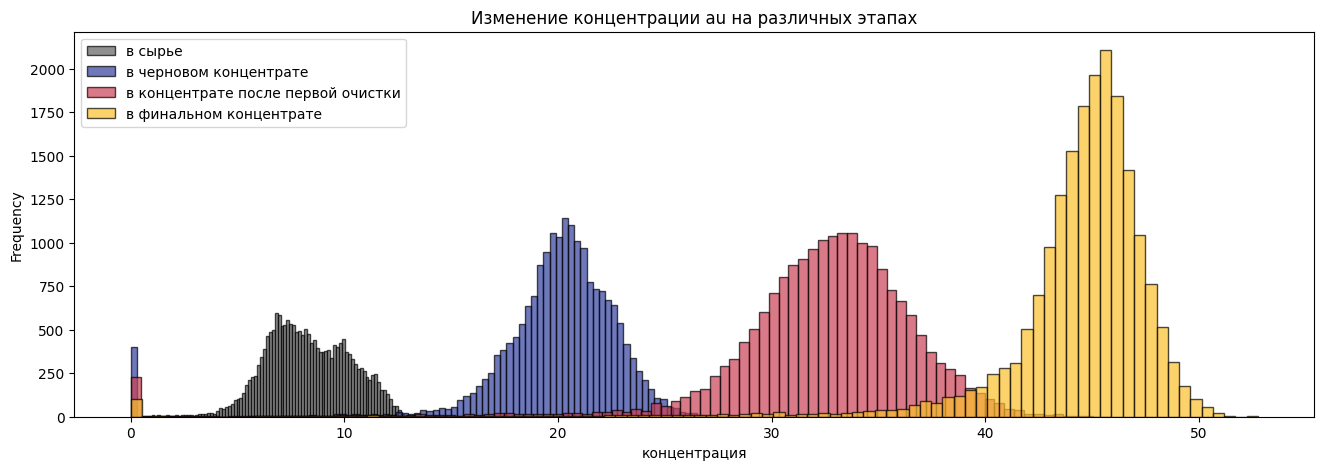

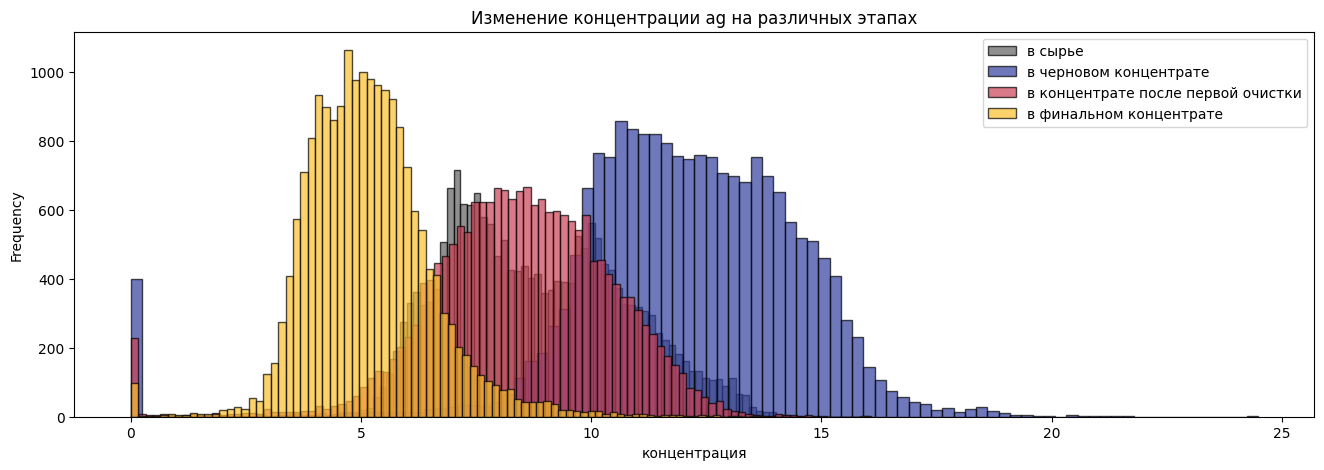

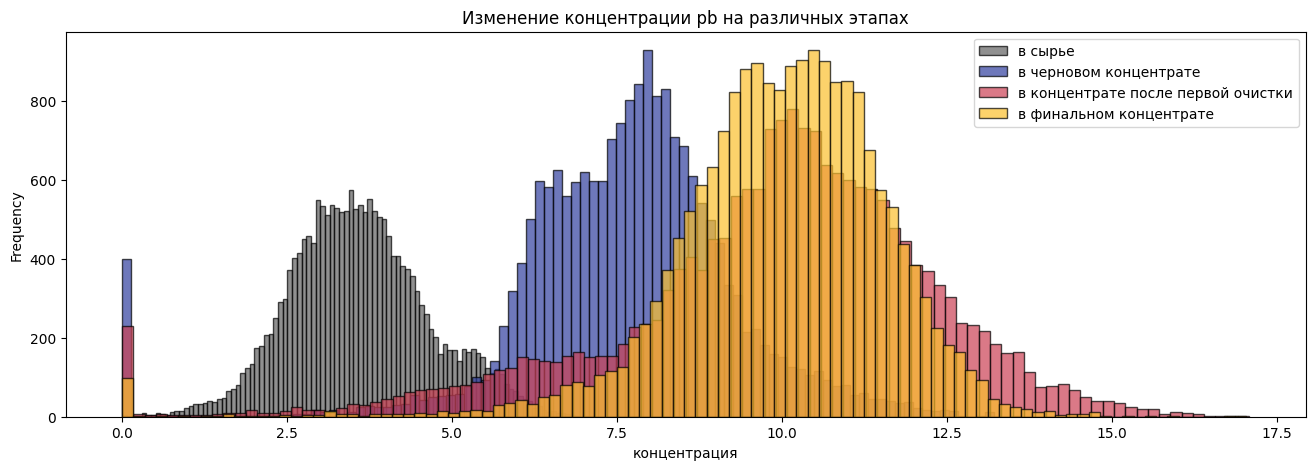

In [29]:
#Перебирая необходимые металлы строим графики для разных этапов
for element in ['au', 'ag', 'pb']:
        
    fig = plt.figure(figsize=(16, 5))
    ax = fig.add_subplot(111)
    ax.set_title(
    f'Изменение концентрации {element} на различных этапах')
    ax.set_xlabel('концентрация')
    ax.set_ylabel('кол-во наблюдений')
    
    df_full[f'rougher_input_feed_{element}'].plot(
    kind = 'hist', label = 'в сырье',
    bins = 100, ax=ax, alpha = 0.7, 
    color = '#616161', edgecolor = 'black');
        
    df_full[f'rougher_output_concentrate_{element}'].plot(
    kind = 'hist', label = 'в черновом концентрате',
    bins = 100, ax=ax, alpha = 0.7, 
    color = '#303F9F', edgecolor = 'black');
        
    df_full[f'primary_cleaner_output_concentrate_{element}'].plot(
    kind = 'hist', label = 'в концентрате после первой очистки',
    bins = 100, ax=ax, alpha = 0.7, 
    color = '#cb4154', edgecolor = 'black');
        
    df_full[f'final_output_concentrate_{element}'].plot(
    kind = 'hist', label = 'в финальном концентрате',
    bins = 100, ax=ax, alpha = 0.7, 
    color = '#FBC02D', edgecolor = 'black');
    
    plt.legend();

Видно как концентрация золота существенно увеличивается после каждого этапа.

Концентрация серебра увеличивается в черновом концентрате до самых своих больших значений, и далее падает.

Концентрация свинца увеличивается в черновом концентрате и после первой очистки, и следующие манипуляции не сильно изменяют эту концентрацию, в финале она остается примерно такой же как и после первой очистки.

На графиках заметны еще некоторые аномалии - значения концентраций около нуля. Они конечно уменьшаются на каждом этапе, но особенно они выглядят аномальными и странными для финального концентрата, что похоже на ошибки измерений.

Посмотрим есть ли в обучающем датафрейме те данные, для которых финальная концентрация нулевая на примере золота: 

In [30]:
df_train.query('final_output_concentrate_au == 0')[['rougher_input_feed_au',
                                                    'rougher_output_concentrate_au',
                                                    'primary_cleaner_output_concentrate_au',
                                                    'final_output_concentrate_au']]

rougher_input_feed_au  rougher_output_concentrate_au  \
516                 5.598971                      15.935190   
943                 7.786147                      18.682162   
944                 7.499248                      18.231121   
945                 7.032278                      18.190655   
946                 7.021635                      18.194323   
...                      ...                            ...   
11553              11.604771                      19.442973   
11554              11.763586                      17.784973   
11754               7.345464                      20.047747   
11755               7.687805                      22.632637   
11856               6.009365                      13.743304   

       primary_cleaner_output_concentrate_au  final_output_concentrate_au  
516                                26.238846                          0.0  
943                                34.564456                          0.0  
944                                34.399450                          0.0  
945                                34.303756                          0.0  
946                                33.956378                          0.0  
...                                      ...                          ...  
11553                              34.015777                          0.0  
11554                              27.937329                          0.0  
11754                               2.635256                          0.0  
11755                              32.702605                          0.0  
11856                               8.144001                          0.0  

[98 rows x 4 columns]

Для золота таких наблюдений 98, и выглядят они весьма странно, концентрация после предыдущих этапов есть, а в финале нулевая. Посмотрим  для других металлов:

In [31]:
df_train.query('final_output_concentrate_ag == 0')[['rougher_input_feed_ag',
                                                    'rougher_output_concentrate_ag',
                                                    'primary_cleaner_output_concentrate_ag',
                                                    'final_output_concentrate_ag']]

rougher_input_feed_ag  rougher_output_concentrate_ag  \
516                 7.407737                      11.803589   
943                 8.098125                      10.640168   
944                 7.832467                      10.415491   
945                 7.600277                      10.197899   
946                 7.436860                       9.968103   
...                      ...                            ...   
11553              12.464094                      14.424928   
11554              12.726401                      14.028955   
11754               9.398085                      12.043514   
11755               9.812272                      14.639309   
11856               6.503673                       9.522966   

       primary_cleaner_output_concentrate_ag  final_output_concentrate_ag  
516                                 8.986696                          0.0  
943                                 8.701237                          0.0  
944                                 8.697952                          0.0  
945                                 8.921656                          0.0  
946                                 9.239378                          0.0  
...                                      ...                          ...  
11553                               8.415798                          0.0  
11554                              11.517548                          0.0  
11754                               0.634975                          0.0  
11755                               8.735761                          0.0  
11856                               1.834584                          0.0  

[98 rows x 4 columns]

Видно что для серебра это те же самые наблюдения

In [32]:
df_train.query('final_output_concentrate_pb == 0')[['rougher_input_feed_pb',
                                                    'rougher_output_concentrate_pb',
                                                    'primary_cleaner_output_concentrate_pb',
                                                    'final_output_concentrate_pb']]

rougher_input_feed_pb  rougher_output_concentrate_pb  \
516                 1.934178                       7.143475   
943                 2.588661                       7.565854   
944                 2.435125                       7.367937   
945                 2.265148                       7.364725   
946                 2.265435                       7.282737   
...                      ...                            ...   
11553               5.393215                       8.120457   
11554               5.630816                       8.029784   
11754               2.653756                       9.540977   
11755               2.738460                       6.588981   
11856               2.522602                       4.906476   

       primary_cleaner_output_concentrate_pb  final_output_concentrate_pb  
516                                 6.530607                          0.0  
943                                 7.234158                          0.0  
944                                 7.119325                          0.0  
945                                 6.637383                          0.0  
946                                 6.249012                          0.0  
...                                      ...                          ...  
11553                              10.210094                          0.0  
11554                              11.462232                          0.0  
11754                               0.090132                          0.0  
11755                               7.265347                          0.0  
11856                               2.338291                          0.0  

[98 rows x 4 columns]

И для свинца также. Может можно было подумать и заморочиться как-то заменить их исходя из предыдущих или последующих по времени наблюдений, но их число не велико, поэтому просто удалим эти 98 наблюдений из датафрейма:

In [33]:
#Запоминаем индексы этих наблюдений
index = df_train.query('final_output_concentrate_au == 0').index

#Удаляем
df_train.drop(index, inplace = True)

#Обновим индексацию датафрейма
df_train.reset_index(drop=True, inplace= True)

#Проверяем
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14481 entries, 0 to 14480
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                14481 non-null  datetime64[ns]
 1   rougher_input_feed_au                               14481 non-null  float64       
 2   rougher_input_feed_ag                               14481 non-null  float64       
 3   rougher_input_feed_pb                               14481 non-null  float64       
 4   rougher_input_feed_sol                              14481 non-null  float64       
 5   rougher_input_feed_rate                             14481 non-null  float64       
 6   rougher_input_feed_size                             14481 non-null  float64       
 7   rougher_input_floatbank10_sulfate                   14481 non-null  float64       
 8   roughe

#### 2.2. Исследуем суммарную концентрацию металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

In [34]:
#Формируем столбец с суммарной концентрацией в сырье
sum_r_input_concentrate = df_full['rougher_input_feed_au'] +\
df_full['rougher_input_feed_ag'] + df_full['rougher_input_feed_pb']

#Формируем столбец с суммарной концентрацией в черновом концентрате
sum_r_output_concentrate = df_full['rougher_output_concentrate_au'] + \
df_full['rougher_output_concentrate_ag'] + df_full['rougher_output_concentrate_pb']

#Формируем столбец с суммарной концентрацией после первой очистки
sum_pr_output_concentrate =  df_full['primary_cleaner_output_concentrate_au'] +\
df_full['primary_cleaner_output_concentrate_ag'] + \
df_full['primary_cleaner_output_concentrate_pb']

#Формируем столбец с суммарной концентрацией в финальном концентрате
sum_final_concentrate = df_full['final_output_concentrate_au'] + \
df_full['final_output_concentrate_ag'] + df_full['final_output_concentrate_pb']


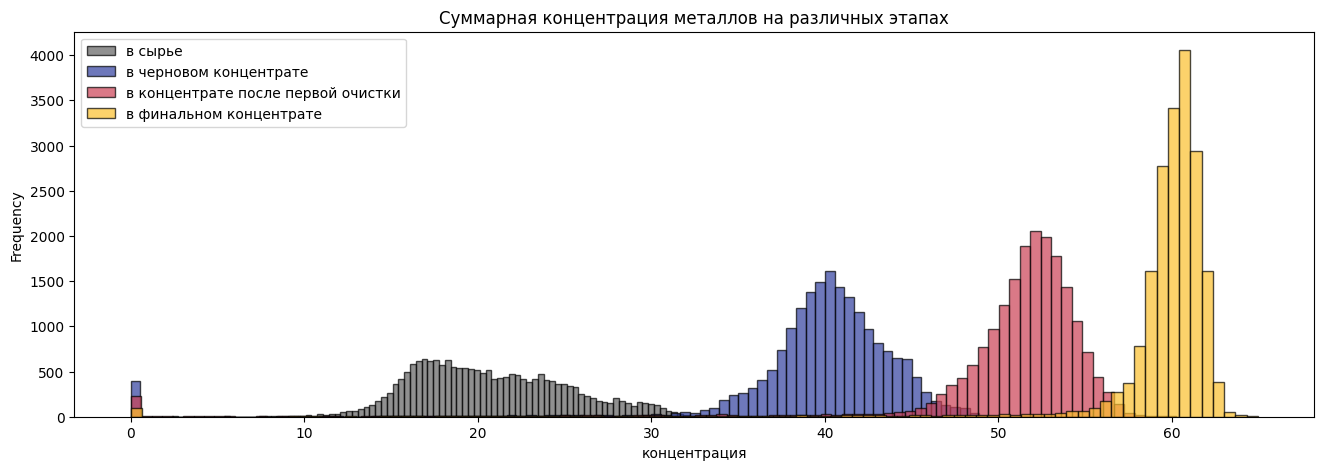

In [35]:
# строим графики для разных этапов
        
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(111)
ax.set_title( 'Суммарная концентрация металлов на различных этапах')
ax.set_xlabel('концентрация')
ax.set_ylabel('кол-во наблюдений')
    
sum_r_input_concentrate.plot(kind = 'hist', label = 'в сырье',
                             bins = 100, ax=ax, alpha = 0.7, 
                             color = '#616161', edgecolor = 'black')
        
sum_r_output_concentrate.plot(kind = 'hist', label = 'в черновом концентрате',
                              bins = 100, ax=ax, alpha = 0.7, 
                              color = '#303F9F', edgecolor = 'black');
        
sum_pr_output_concentrate.plot(kind = 'hist', label = 'в концентрате после первой очистки',
                               bins = 100, ax=ax, alpha = 0.7, 
                               color = '#cb4154', edgecolor = 'black');
        
sum_final_concentrate.plot(kind = 'hist', label = 'в финальном концентрате',
                               bins = 100, ax=ax, alpha = 0.7,
                               color = '#FBC02D', edgecolor = 'black');
    
plt.legend();

 На графике видно, что общая концентрация металлов растет после каждого следующего этапа, а разброс уменьшается, что соответствует здравому смыслу.
 
 Также заметно, что есть нулевые и околонулевые значения суммарных концентрацией. Скорее всего это связано со сбоем измерительного оборудования. Удалим такие наблюдения из обучающих данных:

In [36]:
#Формируем столбец с суммарной концентрацией в сырье по обущающим данным
sum_r_input_concentrate_train = df_train['rougher_input_feed_au'] +\
df_train['rougher_input_feed_ag'] + df_train['rougher_input_feed_pb']

#столбец с суммарной концентрацией в черновом концентрате
sum_r_output_concentrate_train = df_train['rougher_output_concentrate_au'] + \
df_train['rougher_output_concentrate_ag'] + df_train['rougher_output_concentrate_pb']

#столбец с суммарной концентрацией после первой очистки
sum_pr_output_concentrate_train =  df_train['primary_cleaner_output_concentrate_au'] +\
df_train['primary_cleaner_output_concentrate_ag'] + \
df_train['primary_cleaner_output_concentrate_pb']

#столбец с суммарной концентрацией в финальном концентрате
sum_final_concentrate_train = df_train['final_output_concentrate_au'] + \
df_train['final_output_concentrate_ag'] + df_train['final_output_concentrate_pb']


In [37]:
#Запоминаем индексы таких наблюдений
index_for_delete = []
index_for_delete.extend(sum_r_input_concentrate_train.loc[ lambda x : x <= 2].index)
index_for_delete.extend(sum_r_output_concentrate_train.loc[ lambda x : x <= 4].index)
index_for_delete.extend(sum_pr_output_concentrate_train.loc[ lambda x : x <= 5].index)
index_for_delete.extend(sum_final_concentrate_train.loc[ lambda x : x <= 6].index)

In [38]:
#Удаляем
df_train.drop(index_for_delete, inplace = True)

#Обновим индексацию датафрейма
df_train.reset_index(drop=True, inplace= True)

#Проверяем
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13862 entries, 0 to 13861
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                13862 non-null  datetime64[ns]
 1   rougher_input_feed_au                               13862 non-null  float64       
 2   rougher_input_feed_ag                               13862 non-null  float64       
 3   rougher_input_feed_pb                               13862 non-null  float64       
 4   rougher_input_feed_sol                              13862 non-null  float64       
 5   rougher_input_feed_rate                             13862 non-null  float64       
 6   rougher_input_feed_size                             13862 non-null  float64       
 7   rougher_input_floatbank10_sulfate                   13862 non-null  float64       
 8   roughe

#### 2.3. Сравним распределения размеров гранул исходного сырья на обучающей и тестовой выборках.

Если распределения будут сильно отличаются друг от друга, оценка модели будет неправильной.

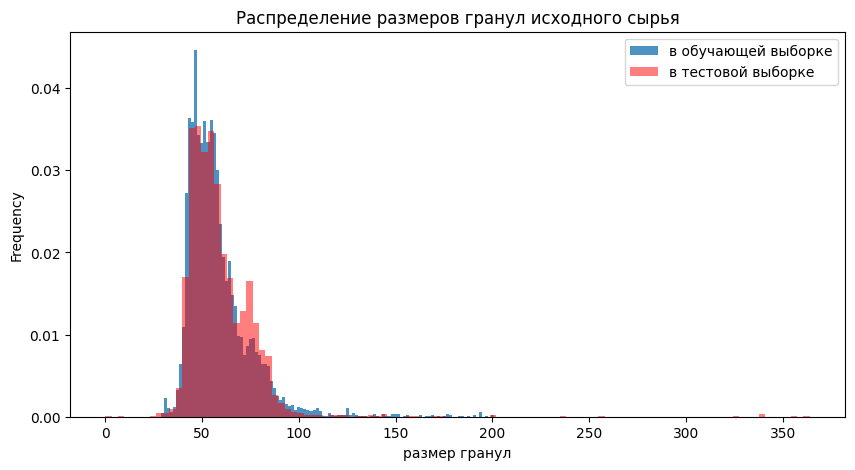

In [39]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_title(
    f'Распределение размеров гранул исходного сырья')
ax.set_xlabel('размер гранул')
ax.set_ylabel('доля наблюдений')
    
df_train['rougher_input_feed_size'].plot(
    kind = 'hist', label = 'в обучающей выборке',
    bins = 110, alpha=0.8,
    density = True, #нормализация
    ax=ax)
        
df_test['rougher_input_feed_size'].plot(
    kind = 'hist', label = 'в тестовой выборке',
    bins = 110, alpha=0.5,
    color = 'r', density = True,
    ax=ax)
    
plt.legend();

Распределение размеров гранул исходного сырья очень похожи, для моделирования нас такая картина устраивает.

<a id='section_3'></a>
### Шаг 3. Построение моделей

#### 3.1. Функция для вычисления итоговой sMAPE

Для решения задачи будем использовать метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).
Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Симметричная, потому что она одинаково учитывает масштаб и целевого признака, и предсказания.

Метрика sMAPE вычисляется следующим образом:

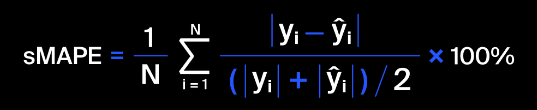

Где Yi - начение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество.

Y с крышечкой - значение предсказания для объекта с порядковым номером i.

N - количество объектов в выборке.

Напомним, что мы должны спрогнозировать две величины:
* эффективность обогащения чернового концентрата rougher_output_recovery;
* эффективность обогащения финального концентрата final_output_recovery.

Итоговая метрика складывается из двух величин:

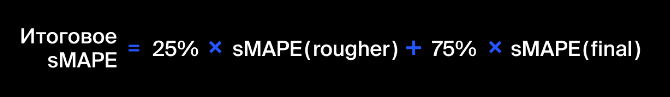

Напишем функцию для вычисления sMAPE

In [40]:
def smape(true, predict):
    """
    Функция для расчета метрики sMAPE
    На вход принимает целевые значения и значения предсказаний
    """
    smape = (1/len(true))*np.sum(
        (np.abs(true - predict))/((np.abs(true)+np.abs(predict))/2))*100
    return smape

In [41]:
def final_smape(rougher, final):
    """
    Функция для расчета итоговой sMAPE
    На вход принимает sMAPE чернового концентрата 
    и SMAPE финального
    """
    final = 0.25*rougher+0.75*final
    return final

In [42]:
smape_score = make_scorer(smape)

#### 3.2. Уберем из обучающего датафрейма ненужные признаки:

In [43]:
diff = df_train.columns.difference(df_test.columns)
diff

Index(['final_output_concentrate_ag', 'final_output_concentrate_au',
       'final_output_concentrate_pb', 'final_output_concentrate_sol',
       'final_output_tail_ag', 'final_output_tail_au', 'final_output_tail_pb',
       'final_output_tail_sol', 'primary_cleaner_output_concentrate_ag',
       'primary_cleaner_output_concentrate_au',
       'primary_cleaner_output_concentrate_pb',
       'primary_cleaner_output_concentrate_sol',
       'primary_cleaner_output_tail_ag', 'primary_cleaner_output_tail_au',
       'primary_cleaner_output_tail_pb', 'primary_cleaner_output_tail_sol',
       'rougher_calculation_au_pb_ratio',
       'rougher_calculation_floatbank10_sulfate_to_au_feed',
       'rougher_calculation_floatbank11_sulfate_to_au_feed',
       'rougher_calculation_sulfate_to_au_concentrate',
       'rougher_output_concentrate_ag', 'rougher_output_concentrate_au',
       'rougher_output_concentrate_pb', 'rougher_output_concentrate_sol',
       'rougher_output_tail_ag', 'rougher_outp

In [44]:
df_train = df_train.drop(np.array(diff), axis=1)

#Проверяем
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13862 entries, 0 to 13861
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        13862 non-null  datetime64[ns]
 1   rougher_input_feed_au                       13862 non-null  float64       
 2   rougher_input_feed_ag                       13862 non-null  float64       
 3   rougher_input_feed_pb                       13862 non-null  float64       
 4   rougher_input_feed_sol                      13862 non-null  float64       
 5   rougher_input_feed_rate                     13862 non-null  float64       
 6   rougher_input_feed_size                     13862 non-null  float64       
 7   rougher_input_floatbank10_sulfate           13862 non-null  float64       
 8   rougher_input_floatbank10_xanthate          13862 non-null  float64       
 9   roughe

Также уберем и признак `date`

In [45]:
df_train = df_train.drop(['date'], axis=1)

#Проверяем
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13862 entries, 0 to 13861
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rougher_input_feed_au                       13862 non-null  float64
 1   rougher_input_feed_ag                       13862 non-null  float64
 2   rougher_input_feed_pb                       13862 non-null  float64
 3   rougher_input_feed_sol                      13862 non-null  float64
 4   rougher_input_feed_rate                     13862 non-null  float64
 5   rougher_input_feed_size                     13862 non-null  float64
 6   rougher_input_floatbank10_sulfate           13862 non-null  float64
 7   rougher_input_floatbank10_xanthate          13862 non-null  float64
 8   rougher_state_floatbank10_a_air             13862 non-null  float64
 9   rougher_state_floatbank10_a_level           13862 non-null  float64
 10  rougher_st

Поделим признаки на общие и целевые. Из общих признаков для модели прогноза чернового концентрата уберем признаки первичной и вторичной очистки. 

In [46]:
features_list = df_train.columns
list_to_cut = features_list[features_list.str.contains('primary|secondary|recovery')]

In [47]:
#Делим данные на общие и целевые признаки
features_rougher= df_train.drop(np.array(list_to_cut), axis=1)
features_final = df_train.drop(
    ['rougher_output_recovery','final_output_recovery'], axis=1)
target_rougher = df_train['rougher_output_recovery']
target_final = df_train['final_output_recovery']

#### 3.3. Обучим разные модели и оценим их качество кросс-валидацией

#### 3.3.1 Модель дерева решений

In [48]:
%%time

best_depth_tree_r = 0
best_rougher_score_tree = 100

#Подбирая в цикле оптимальние гиперпараметры
for depth in range (1, 10, 1):
    
    #Создаем и оцениваем модель для чернового концентрата
    model_for_rougher = DecisionTreeRegressor(random_state = 123, max_depth = depth)
    scores_rougher = cross_val_score(
        model_for_rougher, 
        features_rougher, 
        target_rougher, 
        cv=5, 
        scoring=smape_score)
    rougher_score = scores_rougher.mean()

    if rougher_score < best_rougher_score_tree :
        best_depth_tree_r = depth
        best_rougher_score_tree = rougher_score

print(f'Ср. оценка качества для чернового концентрата = {best_rougher_score_tree:.2f}')
print( 'Максимальная глубина =', best_depth_tree_r)


Ср. оценка качества для чернового концентрата = 6.32
Максимальная глубина = 2
CPU times: total: 2.78 s
Wall time: 5.22 s


In [49]:
%%time

best_depth_tree_f = 0
best_final_score_tree = 100

#Подбирая в цикле оптимальние гиперпараметры
for depth in range (1, 10, 1):
    
    #Создаем и оцениваем модель для чернового концентрата
    model_for_final = DecisionTreeRegressor(
        random_state = 123, max_depth = depth)
    scores_final = cross_val_score(
        model_for_final, 
        features_final, 
        target_final, 
        cv=5, 
        scoring=smape_score)
    final_score = scores_final.mean()

    if final_score < best_final_score_tree :
        best_depth_tree_f = depth
        best_final_score_tree = final_score

print(f'Ср. оценка качества для итогового концентрата = {best_final_score_tree:.2f}')
print( 'Максимальная глубина =', best_depth_tree_f)


Ср. оценка качества для итогового концентрата = 8.91
Максимальная глубина = 2
CPU times: total: 6.88 s
Wall time: 12.2 s


In [50]:
#Посчитаем итоговую sMAPE
result_tree = final_smape(best_rougher_score_tree, best_final_score_tree)

print (f'Итоговая sMAPE = {result_tree:.2f}')


Итоговая sMAPE = 8.27


In [51]:
df_train['final_output_recovery'].mean()

67.27423206558325

Для дерева решений неплохая итоговая метрика sMAPE = 8.27.

Посмотрим на модель линейной регрессии:

#### 3.3.2 Модель линейной регрессии

In [52]:
%%time

#Создаем и оцениваем модель для чернового концентрата
model_for_rougher = LinearRegression()
scores_rougher = cross_val_score(
    model_for_rougher, 
    features_rougher, 
    target_rougher, 
    cv=5, 
    scoring=smape_score)
rougher_score = scores_rougher.mean()
print(f'Ср. оценка качества для чернового концентрата = {rougher_score:.2f}')

#Создаем и оцениваем модель для финального концентрата
model_for_final = LinearRegression()
scores_final = cross_val_score(
    model_for_final, 
    features_final, 
    target_final, 
    cv=5, 
    scoring=smape_score)
final_score = scores_final.mean()
print(f'Ср. оценка качества для финального концентрата = {final_score:.2f}')

#Посчитаем итоговую sMAPE
print (f'Итоговая sMAPE = {final_smape(rougher_score, final_score):.2f}')


Ср. оценка качества для чернового концентрата = 6.56
Ср. оценка качества для финального концентрата = 9.40
Итоговая sMAPE = 8.69
CPU times: total: 734 ms
Wall time: 251 ms


Для линейной регрессии итоговая метрика sMAPE уже немного хуже = 8.69.

Посмотрим на модель случайного леса:

#### 3.3.1 Модель случайного леса

In [53]:
%%time

best_est_forest_r = 0
best_depth_forest_r = 0
best_rougher_score_forest = 100

#Подбирая в цикле оптимальние гиперпараметры
for est in range(10, 60, 20):
    for depth in range (1, 8, 2):

        #Создаем и оцениваем модель для чернового концентрата
        model_for_rougher = RandomForestRegressor(
            random_state=123, 
            n_estimators=est, 
            max_depth=depth)
        
        scores_rougher = cross_val_score(
            model_for_rougher, 
            features_rougher, 
            target_rougher, 
            cv=5, 
            scoring=smape_score)
        rougher_score = scores_rougher.mean()
        
        if rougher_score < best_rougher_score_forest:
            best_est_forest_r = est
            best_depth_forest_r = depth
            best_rougher_score_forest = rougher_score

print(f'Ср. оценка качества для чернового концентрата = \
{best_rougher_score_forest:.2f}')
print('Количество деревьев =', best_est_forest_r, \
      'Максимальная глубина =', best_depth_forest_r)


Ср. оценка качества для чернового концентрата = 5.98
Количество деревьев = 10 Максимальная глубина = 3
CPU times: total: 47.3 s
Wall time: 1min 44s


In [54]:
%%time

best_est_forest_f = 0
best_depth_forest_f = 0
best_final_score_forest = 100

#Подбирая в цикле оптимальние гиперпараметры
for est in range(10, 80, 20):
    for depth in range (1, 8, 2):

        #Создаем и оцениваем модель для финального концентрата
        model_for_final = RandomForestRegressor(
            random_state=123, 
            n_estimators=est, 
            max_depth=depth)
        
        scores_final = cross_val_score(
            model_for_final, 
            features_final, 
            target_final, 
            cv=5, 
            scoring=smape_score)
        final_score = scores_final.mean()

        if final_score < best_final_score_forest:
            best_est_forest_f = est
            best_depth_forest_f = depth
            best_final_score_forest = final_score
            
print(f'Ср. оценка качества для финального концентрата =\
{best_final_score_forest:.2f}')
print('Количество деревьев =', best_est_forest_f, \
      'Максимальная глубина =', best_depth_forest_f)


Ср. оценка качества для финального концентрата =9.01
Количество деревьев = 70 Максимальная глубина = 3
CPU times: total: 3min 53s
Wall time: 7min 18s


In [55]:
#Посчитаем итоговую sMAPE
result_forest = final_smape(best_rougher_score_forest, best_final_score_forest)

print (f'Итоговая sMAPE = {result_forest:.2f}')


Итоговая sMAPE = 8.25


Лучше всего показала себя модель случайного леса (sMAPE = 8.25).

#### Выводы по итогу построения моделей:

Значения метрик sMAPE для моделей:

|Модель  |sMAPE на черновом концентрате|sMAPE на финальном концентрате|итоговая sMAPE|
|:----:|:----:|:----:|:----:|
|Дерево решений |6.32|8.91|8.27|
|Линейная регрессия |6.56|9.40|8.69|
|Случайный лес |5.98|9.01|8.25|  

Дерево решений и случайный лес показывают очень хорошие результаты. 

Но остановим свой выбор на наилучшей модели - модели случайного леса

<a id='section_4'></a>
### Шаг 4. Тестирование и проверка на адекватность выбранной модели

#### 4.1 Проверка лучшей модели на тестовой выборке

In [56]:
features_list = df_test.columns
list_to_cut = features_list[
    features_list.str.contains('primary|secondary|recovery|date')]

In [57]:
#Делим тестовые данные на общие и целевые признаки
features_rougher_test = df_test.drop(np.array(list_to_cut), axis=1)
features_final_test = df_test.drop(
    ['date', 'rougher_output_recovery','final_output_recovery'], axis=1)
target_rougher_test = df_test['rougher_output_recovery']
target_final_test = df_test['final_output_recovery']

In [58]:
#Наша выбранная модель с лучшими параметрами для чернового концентрата
model_for_rougher = RandomForestRegressor(
    random_state=123, n_estimators=10, max_depth=3)

#Обучаем
model_for_rougher.fit(features_rougher,target_rougher)

#Делаем предсказание на тестовых данных
predicted_rougher = model_for_rougher.predict(features_rougher_test)

#Смотрим оценку
smape_on_rougher_test = smape(target_rougher_test, predicted_rougher)
print(f'Оценка качества модели для чернового концентрата =\
{smape_on_rougher_test:.2f}')


Оценка качества модели для чернового концентрата =4.36


In [59]:
#Наша модель случайного леса с лучшими параметрами для чернового концентрата
model_for_final = RandomForestRegressor(
    random_state=123, n_estimators=70, max_depth=3)

#Обучаем
model_for_final.fit(features_final,target_final)

#Делаем предсказание на тестовых данных
predicted_final = model_for_final.predict(features_final_test)

#Смотрим оценку
smape_on_final_test = smape(target_final_test, predicted_final)
print(f'Оценка качества модели для финального концентрата = \
{smape_on_final_test:.2f}')


Оценка качества модели для финального концентрата = 8.02


In [60]:
print(f'Итоговая оценка качества модели на тестовых данных = \
{final_smape(smape_on_rougher_test , smape_on_final_test):.2f}')

Итоговая оценка качества модели на тестовых данных = 7.10


Хорошие результаты тестирования

#### 4.2 Проверка модели на адекватность

Сравним показатели sMAPE с константной моделью, которая всегда предсказывает среднее значение:

In [61]:
#Создаем и обучаем константную модель для чернового концентрата
dummy_regr_for_rougher = DummyRegressor(strategy="mean")
dummy_regr_for_rougher.fit(features_rougher, target_rougher)

#Делаем предсказание на тестовых данных
dummy_predicted_rougher = dummy_regr_for_rougher.predict(
    features_rougher_test)

#Смотрим оценку
smape_on_rougher = smape(target_rougher_test, dummy_predicted_rougher) 
print(f'Оценка качества константной модели для чернового концентрата = \
{smape_on_rougher :.2f}')

Оценка качества константной модели для чернового концентрата = 6.10


In [62]:
#Создаем и обучаем константную модель для финального концентрата
dummy_regr_for_final = DummyRegressor(strategy="mean")
dummy_regr_for_final.fit(features_final, target_final)

#Делаем предсказание на тестовых данных
dummy_predicted_final = dummy_regr_for_final.predict(features_final_test)

#Смотрим оценку
smape_on_final = smape(target_final_test, dummy_predicted_final)
print(f'Оценка качества константной модели для чернового концентрата = \
{smape_on_final:.2f}')

Оценка качества константной модели для чернового концентрата = 9.26


In [63]:
print(f'Оценка качества константной модели итоговая = \
{final_smape(smape_on_rougher , smape_on_final):.2f}')

Оценка качества константной модели итоговая = 8.47


Метрика sMAPE у нашей модели существенно ниже чем у контантной, что говорит об ее адекватности.

#### 4.3 Важность факторов при прогнозировании:

Посмотрим какие факторы важны при прогнозировании содежания золота в черновом концентрате (топ 15 по убыванию):

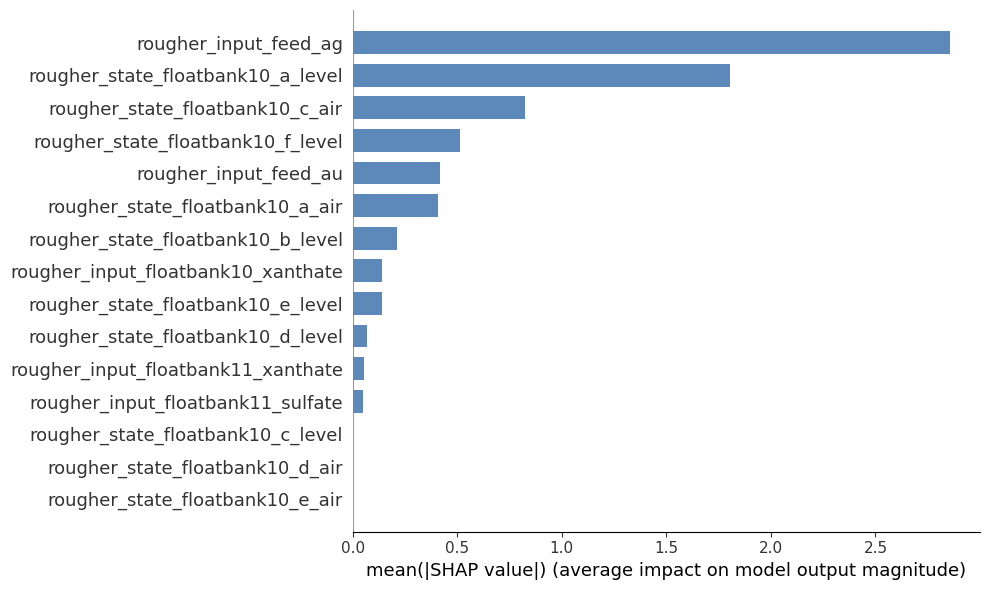

In [64]:
#получим важность признаков
shap_values_rougher = shap.TreeExplainer(
    model_for_rougher).shap_values(features_rougher)

#построим график
shap.summary_plot(
    shap_values_rougher, 
    features_rougher, 
    plot_type="bar",
    plot_size = (10,6),
    color = '#5d89ba',
    max_display = 15)


Самый большой вклад в прогноз вносят такие признаки как серебро в исходном сырье `rounger_input_feed_ag`, состояние флотационной установки жидкостью `rougher_state_floatbank10_a_level` и состояние флотационной установки воздухом`rougher_state_floatbank10_c_air`.

Некоторые признаки не имеют никакой важности для прогноза, их получается можно было бы даже удалить из датасета.

Дополнительно посмотрим положительные и отрицательные отношения признаков с целевой переменной:

In [65]:
#Цветовая карта для нашего графика
new_cmap = LinearSegmentedColormap.from_list("", ['#1976D2','#cb4154'])

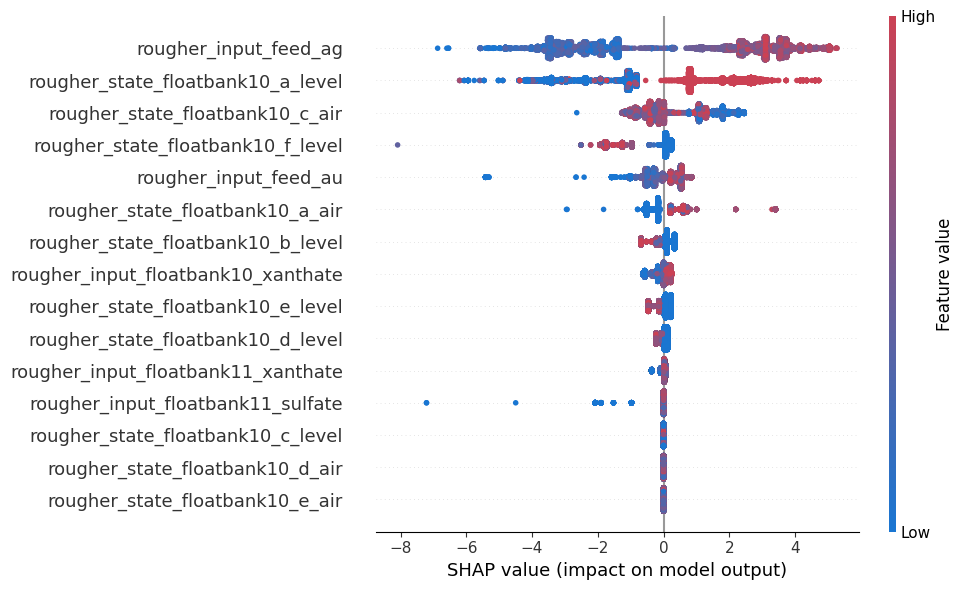

In [66]:
shap.summary_plot(
    shap_values_rougher, 
    features_rougher, 
    max_display=15, 
    cmap = new_cmap,
    plot_size = (10,6));

Чем выше значение `rounger_input_feed_ag` или выше `rougher_state_floatbank10_a_level`, тем выше коэффициент содержания золота в черновом концентрате. Обратное утверждение также справедливо.

Чем меньше `rougher_state_floatbank10_c_air`, тем выше коэффициент содержания золота в черновом концентрате. Обратное утверждение также справедливо.

Посмотрим какие факторы важны при прогнозировании содежания золота в финальном концентрате (топ 15 по убыванию):

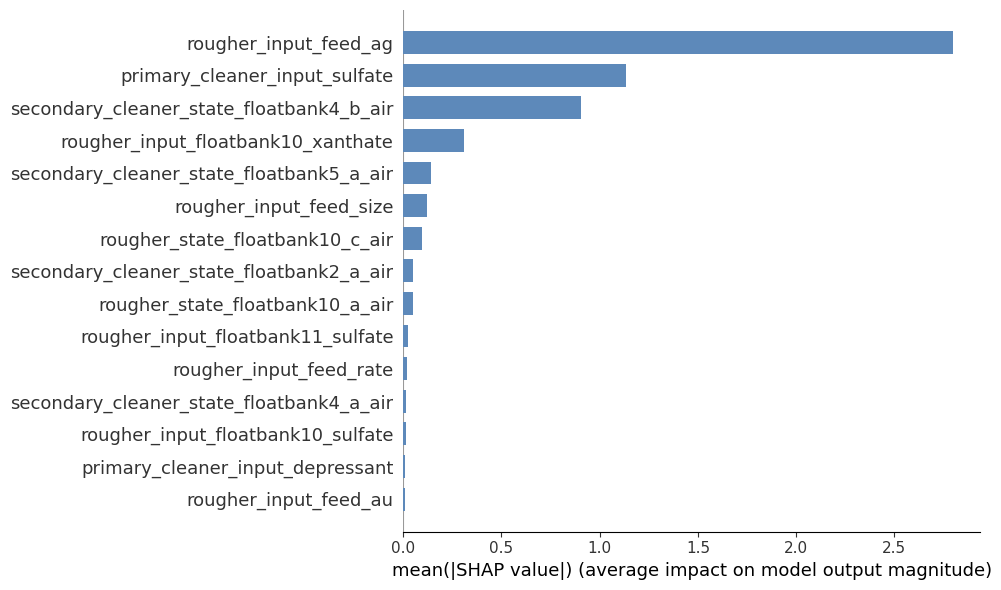

In [67]:
#получим важность признаков
shap_values_final = shap.TreeExplainer(
    model_for_final).shap_values(features_final)

#построим график
shap.summary_plot(
    shap_values_final, 
    features_final, 
    plot_type="bar",
    plot_size = (10,6),
    color = '#5d89ba',
    max_display = 15)

Больше всего на прогноз содержания золота в финальном концентрате влияет серебро в исходном сырье `rougher_input_feed_ag` и значения сульфата на этапе первичной очистки 
`primary_cleaner_input_sulfate`/

Некоторые признаки аналогично не имеют важности для прогноза, их получается можно было бы даже удалить из датасета.

Дополнительно посмотрим положительные и отрицательные отношения признаков с целевой переменной:

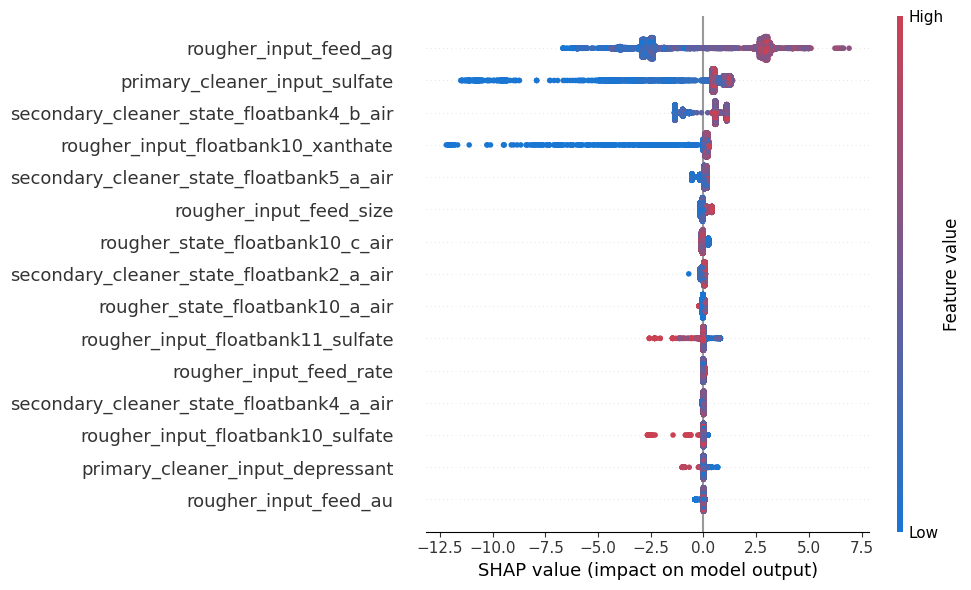

In [68]:
shap.summary_plot(
    shap_values_final, 
    features_final, 
    max_display=15, 
    cmap = new_cmap,
    plot_size = (10,6))

Чем выше значение rounger_input_feed_ag, тем выше коэффициент содержания золота в финальном концентрате, обратное утверждение также справедливо.

Если мало `primary_cleaner_input_sulfate`, то меньше коэффициент содержания золота в финальном концентрате, это справедливо только в одну сторону.


<a id='section_5'></a>
### Шаг 5. Общий вывод


<br/>

#### Цели исследования

Нужно создать модель для предсказания коэффициента восстановления золота из золотосодержащей руды. Предоставлены данные с параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

<br/> 

#### Полученные данные были изучены и прошли следующую предобработку:

* В обучающем датасете у нас содержится информация о 14579 наблюдениях по 87 признакам. В тестовом датасете у нас содержится информация о 4860 наблюдениях по 53 признакам. В общем датасете у нас содержится информация о 19439 наблюдениях по 87 признакам.

* Признаков в тестовой выборке значительно меньше, скорее всего, часть признаков мы не можем знать в момент оценки и предсказаний. Поэтому те признаки, которых нет в тестовом датафрейме мы убрали из обучающего перед моделированием.

* snapecase в названиях соблюден, все маленькими буквами. Все точки в названии  были заменены на нижние подчеркивания.

* С типами данных считаем что все в порядке, только тип данных для признака `data` заменили на datetime. Далее перед самим моделированием данный признак изымался из обучающего датафрейма, так как  по логике он не должен оказывать влияния на коэффициент восстановления золота из руды.

* В тестовый датафрейм из общего датафрейма были добавлены целевые признаки final.output.recovery и rougher.output.recovery

* В обучающем датафрейме были обнаружены выбросы/аномальные данные в следующих признаках (из тех, что будут участвовать в моделировании):

        rougher_input_feed_size
        rougher_state_floatbank10_a_air
        rougher_state_floatbank10_f_air
        rougher_state_floatbank10_e_air

    Аномальные данные в данных признаках были обрезаны (заменены на пустые знгачения) по 0.4 процентиля слева и справа.
    
* В тестовом датафрейме выбросов и аномальных данных можно сказать нет. 

* В общем датафрейме похоже на выбросы или наличие аномальных данных в следующих признаках:

        rougher_input_feed_size
        rougher_state_floatbank10_a_air
        rougher_state_floatbank10_f_air
        rougher_state_floatbank10_e_air
        'rougher_calculation_sulfate_to_au_concentrate'
        rougher_calculation_floatbank10_sulfate_to_au_feed
        rougher_calculation_floatbank11_sulfate_to_au_feed
        rougher_calculation_au_pb_ratio
        secondary_cleaner_output_tail_au
        final_output_concentrate_au

    Общий датафрейм оставили без изменений.
    
* Была проведена проверка, что эффективность обогащения рассчитана правильно для признака rougher_output_recovery. Была посчитана метрика MAE между вычисленной эффективностью и имеющейся. Ответы совпадают с точностью до 13 знака после запятой, что говорит о том, что эффективность обогащения рассчитана верно.

* Во всех датафреймах были обнаружены пропуски в данных. В обучающем и тестовом датафрейме пропуски были удалены с помощью метода ffill

* Дубликатов наблюдений в датафреймах не обнаружено.


<br/>


#### Анализ данных:

* Было проанализировано как меняется концентрация металлов (Au, Ag, Pb) на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате:
    
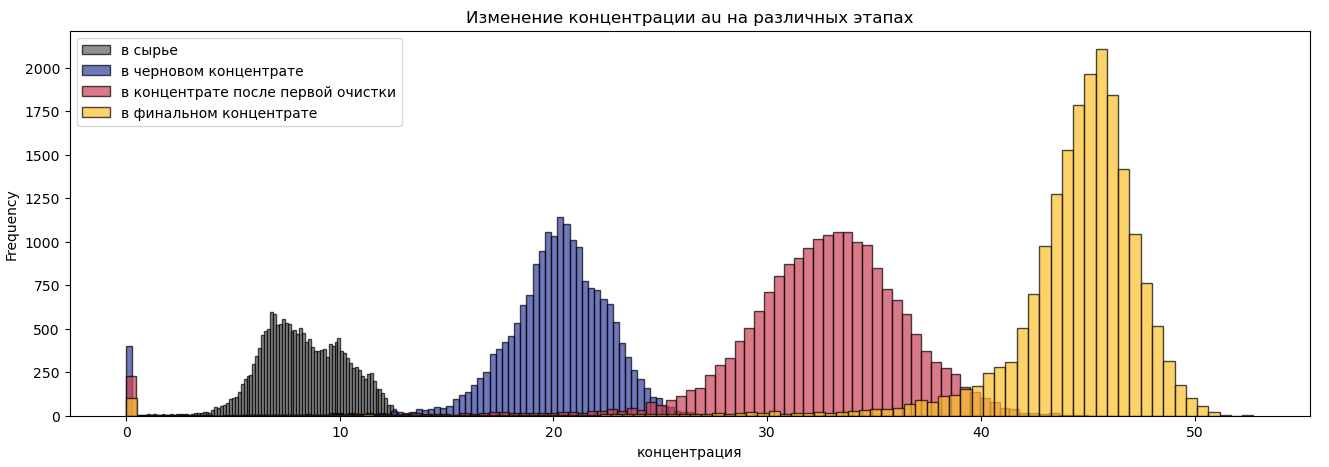

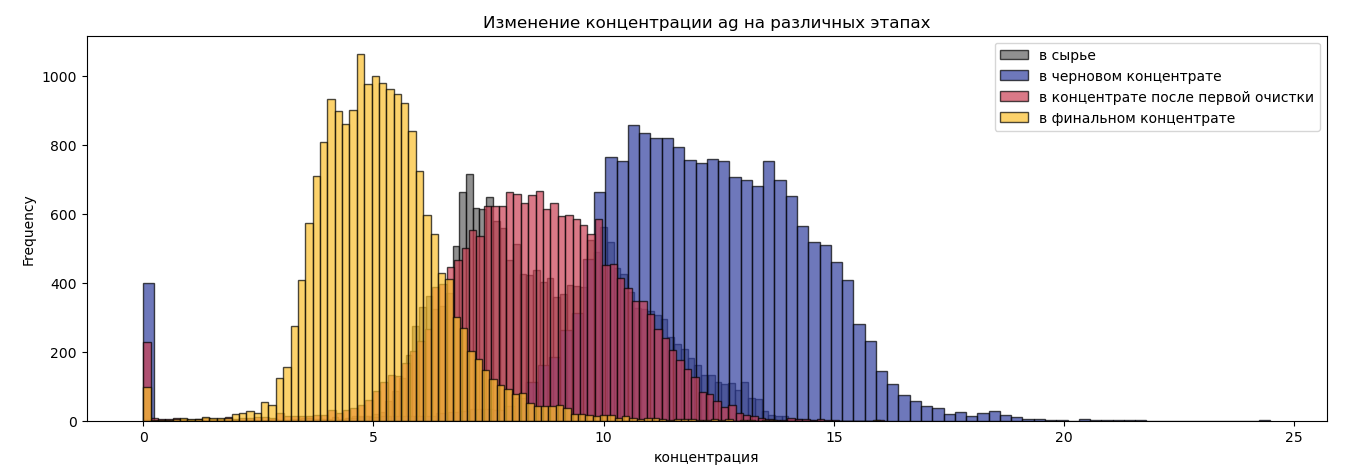

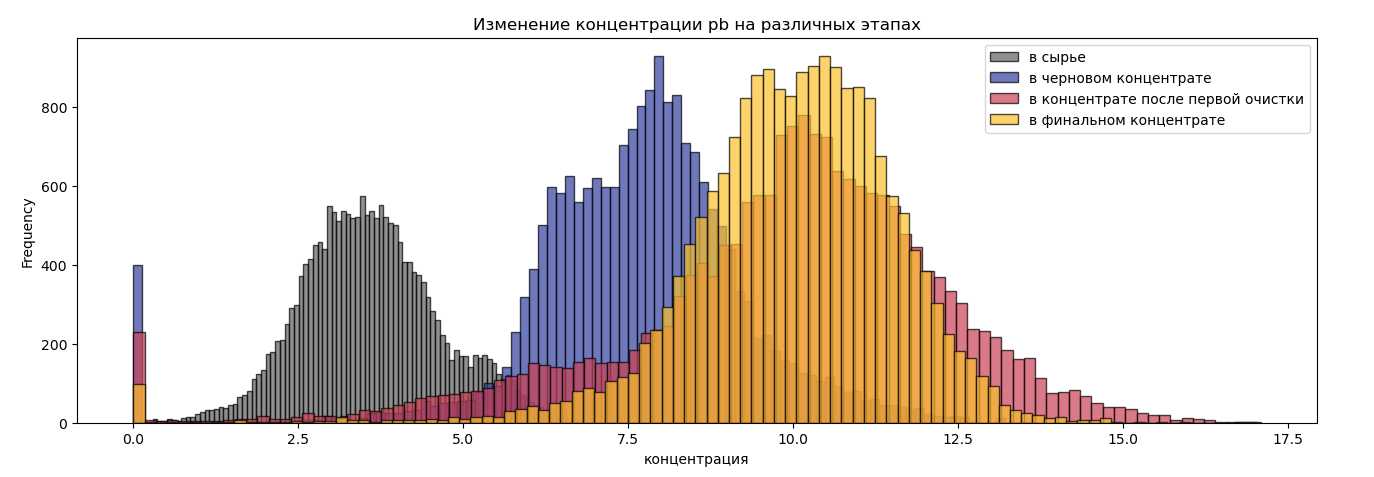

Видно как концентрация золота существенно увеличивается после каждого этапа.

Концентрация серебра увеличивается в черновом концентрате до самых своих больших значений, и далее падает.

Концентрация свинца увеличивается в черновом концентрате и после первой очистки, и следующие манипуляции не сильно изменяют эту концентрацию, в финале она остается примерно такой же как и после первой очистки.

На графиках заметны еще некоторые аномалии - значения концентраций около нуля. Они конечно уменьшаются на каждом этапе, но особенно они выглядят аномальными и странными для финального концентрата, что похоже на ошибки измерений.

* Было проанализировано есть ли в обучающем датафрейме те данные, для которых финальная концентрация нулевая на примере золота. Было обнаружено и удалено 98 строк для которых финальная концентрация металлов нулевая. (Причем эта аномалия в наблюдениях были сразу для всех металлов)

* Была исследована суммарная концентрация металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате:

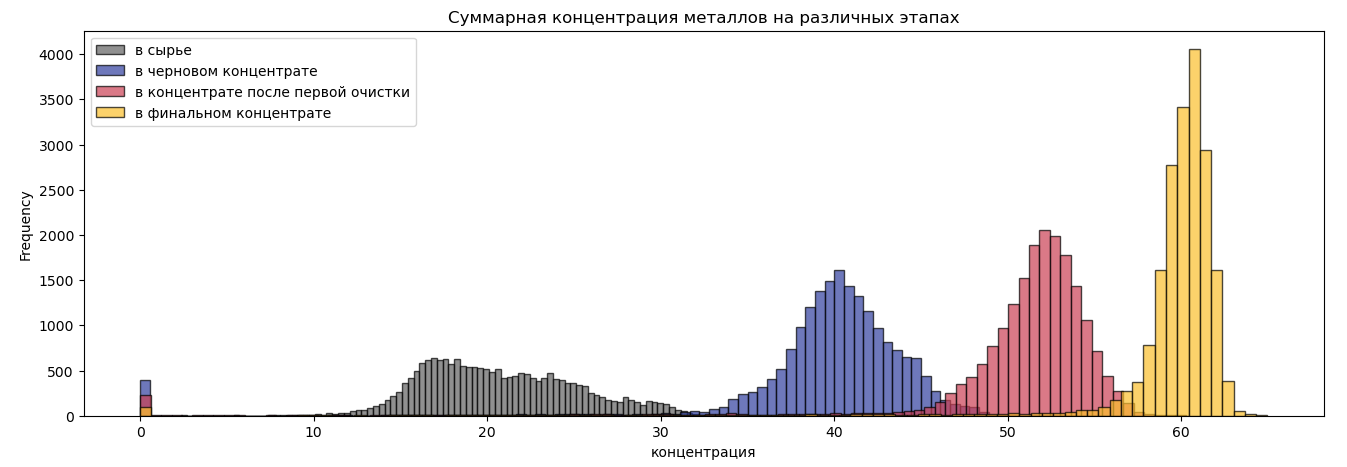

На графике видно что общая концентрация металлов растет после каждого следующего этапа, а разброс уменьшается, что соответствует здравому смыслу.

Также заметно, что есть нулевые и околонулевые значения суммарных концентрацией. Скорее всего это связано со сбоем измерительного оборудования. Такие наблюдения в кол-ве 619 строк были удалены из обучающих данных

* Было произведено сравнение распределения размеров гранул исходного сырья на обучающей и тестовой выборках:

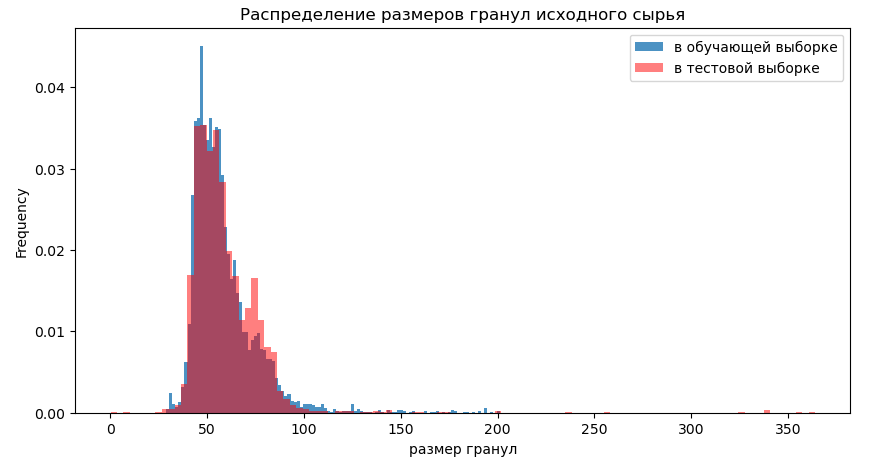

Распределение размеров гранул исходного сырья очень похожи, для моделирования нас такая картина устраивает.

#### Построение моделей:
    
Модели строились для предсказания двух параметров:
    * эффективность обогащения чернового концентрата rougher_output_recovery;
    * эффективность обогащения финального концентрата final_output_recovery.
    
Для оценки использовалась пользовательская метрика sMAPE.
    
Было рассмотрено три регрессионных модели, оценка качества производилась с помощью кросс валидации. Получены следующие результаты:

|Модель  |sMAPE на черновом концентрате|sMAPE на финальном концентрате|итоговая sMAPE|
|:----:|:----:|:----:|:----:|
|Дерево решений |6.32|8.91|8.27|
|Линейная регрессия |6.56|9.40|8.69|
|Случайный лес |5.98|9.01|8.25|  

Дерево решений и случайный лес показывают очень хорошие результаты. 

Но остановим свой выбор на наилучшей модели - модели случайного леса. Лучшие параметры модели:
    * для чернового этапа количество деревьев = 10, максимальная глубина = 3.  
    * для финального этапа количество деревьев = 70, Максимальная глубина = 3.                               

#### Тестирование модели и проверка адекватности:

Для проверки на адекватность использовалась константная модель, предсказывающая среднее значение целевого признака.

По результатам тестирования и проверки на адекватность были получены следующие результаты:

|Модель  |sMAPE на черновом концентрате|sMAPE на финальном концентрате|итоговая sMAPE|
|:----:|:----:|:----:|:----:|
|Случайный лес |4.36|8.02|7.10|
|Константная модель |6.10|9.26|8.47|
  
На тестовых данных модель показала хорошее качество.

Метрика sMAPE у нашей модели существенно ниже чем у контантной, что говорит об ее адекватности. 

**Важность факторов при прогнозировании коэффициента восстановления золота (10 с самой большой важностью):**

* При прогнозировании в черновом концентрате:

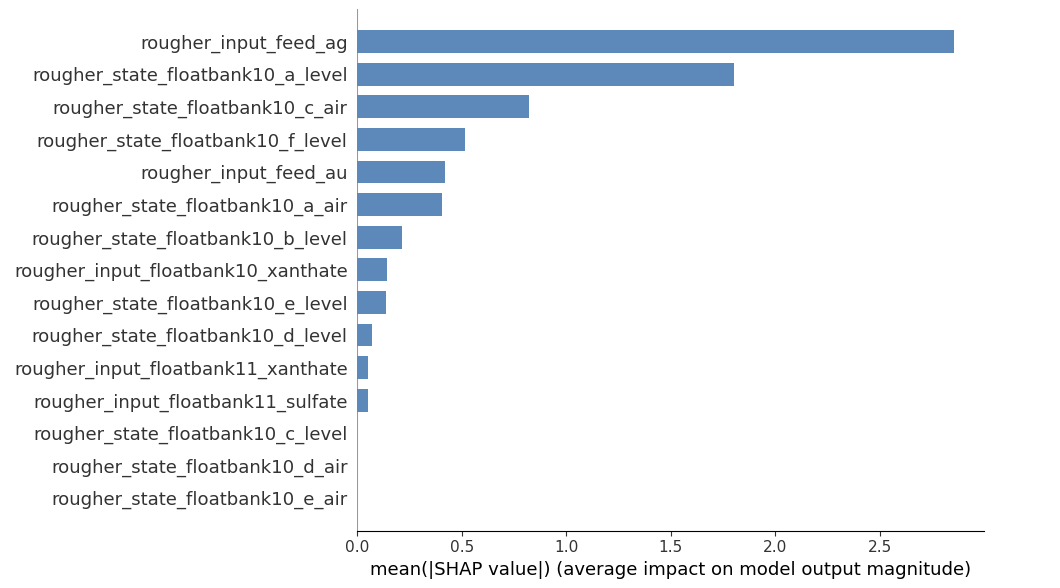

Самый большой вклад в прогноз вносят такие признаки как серебро в исходном сырье `rounger_input_feed_ag`, состояние флотационной установки жидкостью `rougher_state_floatbank10_a_level` и состояние флотационной установки воздухом`rougher_state_floatbank10_c_air`.

Некоторые признаки не имеют никакой важности для прогноза, их получается можно было бы даже удалить из датасета.

Дополнительно были выведены на график положительные и отрицательные отношения признаков с целевой переменной:

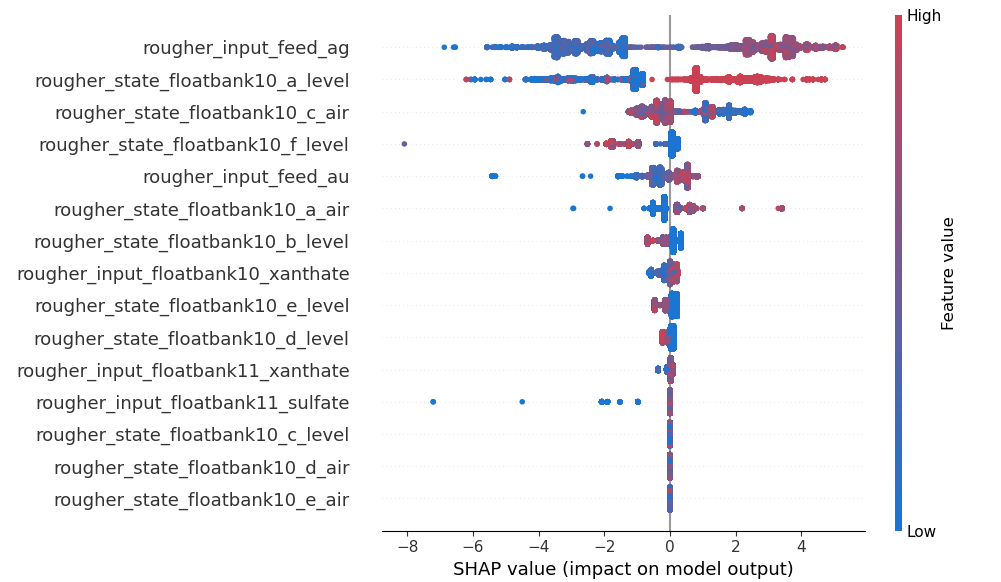

Чем выше значение `rounger_input_feed_ag` или выше `rougher_state_floatbank10_a_level`, тем выше коэффициент содержания золота в черновом концентрате. Обратное утверждение также справедливо.

Чем меньше `rougher_state_floatbank10_c_air`, тем выше коэффициент содержания золота в черновом концентрате. Обратное утверждение также справедливо.

* При прогнозировании в финальном концентрате:

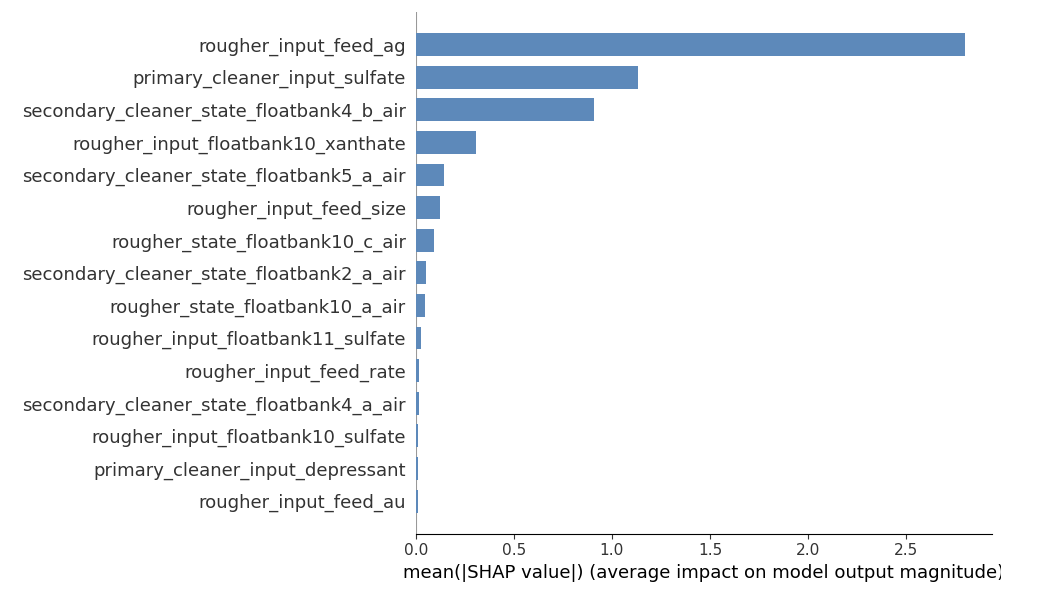

Больше всего на прогноз содержания золота в финальном концентрате влияет серебро в исходном сырье `rougher_input_feed_ag` и значения сульфата на этапе первичной очистки 
`primary_cleaner_input_sulfate`/

Некоторые признаки аналогично не имеют важности для прогноза, их получается можно было бы даже удалить из датасета.

Дополнительно были выведены на график положительные и отрицательные отношения признаков с целевой переменной:

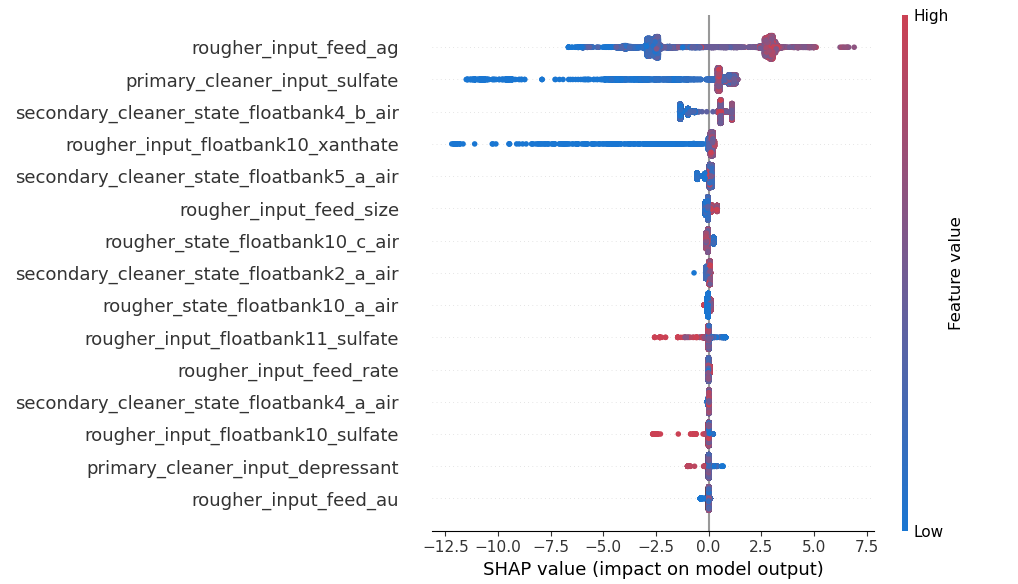

Чем выше значение rounger_input_feed_ag, тем выше коэффициент содержания золота в финальном концентрате, обратное утверждение также справедливо.

Если мало `primary_cleaner_input_sulfate`, то меньше коэффициент содержания золота в финальном концентрате, это справедливо только в одну сторону.

<br/>

### Вывод и рекомендации:

По итогу работы можно рекомендовать модель случайного леса, с указанными выше характеристиками для предсказания коэффициента восстановления золота из золотосодержащей руды.

Мы надеемся, что данная модель поможет оптимизировать работу предприятия, и готовы провести дополнительное исследование, если текущий результат недостаточен для качественной оценки производственного процесса.

<br/>